In [346]:
# Core imports for VCDB analysis
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from collections import defaultdict


sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', None)

DATA_DIR = Path('Datasets/VCDB')

In [347]:
VCDB_CSV_PATH = f"{DATA_DIR}/data/csv/vcdb.csv"
VCDB_MINIMAL_COLUMNS = [
    'incident_id',
    'victim.victim_id',
    'victim.industry',
    'victim.industry.name',
    'summary',
]

def to_code_list(raw) -> list[str]:
    if pd.isna(raw):
        return []
    raw_str = str(raw).strip()
    if not raw_str:
        return []
    return [code.strip() for code in raw_str.split(';') if code.strip()]

def load_vcdb_minimal(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(
        csv_path,
        usecols=VCDB_MINIMAL_COLUMNS,
        dtype={'victim.industry': 'string'},
        low_memory=False,
    ).rename(
        columns={
            'victim.victim_id': 'victim_id',
            'victim.industry': 'industry_code',
            'victim.industry.name': 'industry_name',
        }
    )

    df['industries'] = df['industry_code'].apply(to_code_list)
    return df

vcdb_df = load_vcdb_minimal(VCDB_CSV_PATH)
print(f"Loaded {len(vcdb_df):,} VCDB incidents from CSV")
vcdb_df.head()


Loaded 7,833 VCDB incidents from CSV


,incident_id,summary,industry_code,victim_id,industry_name,industries
0,0001AA7F-C601-424A-B2B8-BE6C9F5164E7,A billing clerk filed a claim for Patient A wi...,923140,United States Department of Veterans Affairs,Public,[923140]
1,0008DADB-E83D-4278-A19A-CEE01610CF43,Patients at an Oregon healthcare facility were...,621111,Corvallis Clinic,Healthcare,[621111]
2,000D403E-2DC9-4EA7-9294-BD3938D1C3C7,Jersey City Medical Center said a computer dis...,622110,Jersey City Medical Center,Healthcare,[622110]
3,0012CC25-9167-40D8-8FE3-3D0DFD8FB6BB,Sensitive information belonging to jobseekers ...,51919,Universal Jobmatch,Information,[51919]
4,00163384-B4D7-46D5-9E6F-543DFB00F598,Veteran A returned a hard copy written prescri...,923140,United States Department of Veterans Affairs,Public,[923140]


In [398]:
# Since we're only focused on things that happened in the US, let's
# go ahead and clean everything up related to countries. Also, we don't
# need things with "plus" attributes.
# extra_cols = ['.country', 'country.', 'currency_code', 'plus', 'pattern', 'timeline.', 'industry2']
extra_cols = ['.country', 'country.', 'currency_code', 'plus', 'pattern', 'industry2']

def drop_extra_cols(column_name):
  return any(keyword in column_name for keyword in extra_cols)

# Sanity check when dropping columns
# for prop in vcdb_properties:
#     print(f"{prop}: {drop_extra_cols(prop)}")

excluded_columns = [col for col in vcdb_properties if drop_extra_cols(col)]
filtered_columns = [col for col in vcdb_properties if col not in excluded_columns]

print(f"Removed {len(excluded_columns):,} columns (country-related or plus)")
print(f"{len(filtered_columns):,} columns remain")

cleaned_df = pd.read_csv(
  VCDB_CSV_PATH,
  usecols=filtered_columns,
  low_memory=False,
)

cleaned_df.to_csv(CLEAN_VCDB_CSV_PATH, index=False)

# for prop in list(cleaned_df.columns):
#     print(f"Property: {prop}")

Removed 1,538 columns (country-related or plus)
859 columns remain


In [399]:
# Let's find out how many events are healthcare related
# Healthcare related incidents have their NAICS code
# set to 62.

def is_healthcare_event(codes):
    return any(str(code).startswith('62') for code in codes)

def to_code_list(raw):
      raw = (raw or '').strip()
      return [raw] if raw else []

cleaned_df['industries'] = cleaned_df['victim.industry'].apply(to_code_list)
cleaned_df['healthcare_event'] = cleaned_df['industries'].apply(is_healthcare_event)
healthcare_df = cleaned_df[cleaned_df['healthcare_event']].copy()

print(f"Total incidents: {len(vcdb_df):,}")
print(f"Healthcare incidents: {len(healthcare_df):,}")

Total incidents: 7,833
Healthcare incidents: 2,171


In [350]:
# Convert revenue to numeric so we can compute ratios
revenue = pd.to_numeric(healthcare_df['victim.revenue.amount'], errors='coerce')

# Calculate the scale factor to properly determine the loss amounts
scale_factor = (upmc_annual_revenue / revenue).replace([np.inf,-np.inf],np.nan).fillna(1.0)
healthcare_df['normalization_factor'] = scale_factor

for col in monetary_cols:
    healthcare_df[col] = pd.to_numeric(healthcare_df[col], errors='coerce') * scale_factor

# After scaling, force every row’s revenue to the UPMC target
healthcare_df['victim.revenue.amount'] = upmc_annual_revenue

In [351]:
# Reference: https://www.tuckerlaw.com/2021/07/28/upmc-finally-settles-data-breach-lawsuit-for-2-7-million/

upmc_payroll_row = {
  'incident_id': 'upmc-2014-payroll-breach',
  'victim.victim_id': 'UPMC',
  'victim.industry': '62',
  'industry_name': 'Healthcare and Social Assistance',
  'industries': ['62'],
  'summary': (
      "Phishing-driven payroll breach exposed W‑2 data for tens of thousands of employees; "
      "UPMC agreed to a $2.7M settlement covering identity protection, monitoring, and fees."
  ),
  'pattern': 'Social Engineering → Use of stolen credentials',
  'notes': 'Synthetic record modeled on Tucker Arensberg report (July 2021) about UPMC’s $2.7M payroll breach settlement.',
  'victim.revenue.amount': upmc_annual_revenue,
  'impact.loss.amount': 2_700_000,
  'impact.loss.min_amount': 2_000_000,
  'impact.loss.max_amount': 3_400_000,
  'impact.overall_amount': 2_700_000,
  'victim.secondary.amount': 405_000,  # 15% allocated to employee remediation
  'timeline.incident.year': 2014,
  'normalization_factor': 1.0,
  'healthcare_event': True,
  'action.Malware': 0,
  'action.Hacking': 1,
  'action.Social': 1,
  'action.Error': 0,
  'action.Physical': 0,
  'action.Misuse': 0,
  'action.Environmental': 0,
  'action.Unknown': 0,
}

for col in healthcare_df.columns:
  upmc_payroll_row.setdefault(col, None)

healthcare_df = pd.concat(
  [healthcare_df, pd.DataFrame([upmc_payroll_row])[healthcare_df.columns]],
  ignore_index=True,
)

/tmp/ipykernel_36409/3575529697.py:37: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [352]:
# Refernece: https://thisweekhealth.com/news_story/upmc-settles-65-million-lawsuit-after-2019-ransomware-attack/

upmc_ransomware_row = {
  'incident_id': 'upmc-2019-ransomware',
  'victim.victim_id': 'UPMC',
  'victim.industry': '62',
  'industry_name': 'Healthcare and Social Assistance',
  'industries': ['62'],
  'summary': (
      "2019 supply-chain ransomware attack on UPMC subsidiary leads to weeks of system disruption and a "
      "$6.5M settlement with patients whose data was exposed."
  ),
  'pattern': 'Malware → Ransomware',
  'notes': 'Synthetic record derived from ThisWeekHealth coverage of UPMC 2019 ransomware settlement (Feb 2024).',
  'victim.revenue.amount': upmc_annual_revenue,
  'impact.loss.amount': 6_500_000,
  'impact.loss.min_amount': 5_000_000,
  'impact.loss.max_amount': 8_000_000,
  'impact.overall_amount': 6_500_000,
  'victim.secondary.amount': 975_000,  # 15% of losses tied to claims / notifications
  'timeline.incident.year': 2019,
  'normalization_factor': 1.0,
  'healthcare_event': True,
  # action flags
  'action.Malware': 1,
  'action.Hacking': 1,
  'action.Social': 0,
  'action.Error': 0,
  'action.Physical': 0,
  'action.Misuse': 0,
  'action.Environmental': 0,
  'action.Unknown': 0,
}

for col in healthcare_df.columns:
  upmc_ransomware_row.setdefault(col, None)

healthcare_df = pd.concat(
  [healthcare_df, pd.DataFrame([upmc_ransomware_row])[healthcare_df.columns]],
  ignore_index=True,
)

/tmp/ipykernel_36409/2840341569.py:38: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [353]:
healthcare_df_csv_path = f"{DATA_DIR}/data/csv/vcdb_healthcare_upmc.csv"
healthcare_df.to_csv(healthcare_df_csv_path, index=False)
print(f"Saved healthcare dataset to {healthcare_df_csv_path}")

Saved healthcare dataset to Datasets/VCDB/data/csv/vcdb_healthcare_upmc.csv


['action.Malware', 'action.Hacking', 'action.Social', 'action.Physical', 'action.Misuse', 'action.Error', 'action.Environmental', 'action.Unknown']


/tmp/ipykernel_36409/3446750620.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




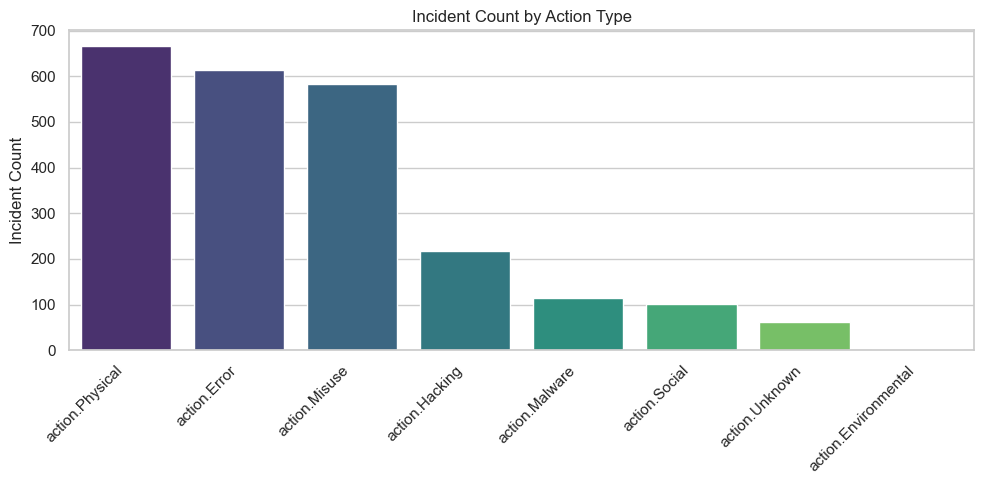

/tmp/ipykernel_36409/3446750620.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




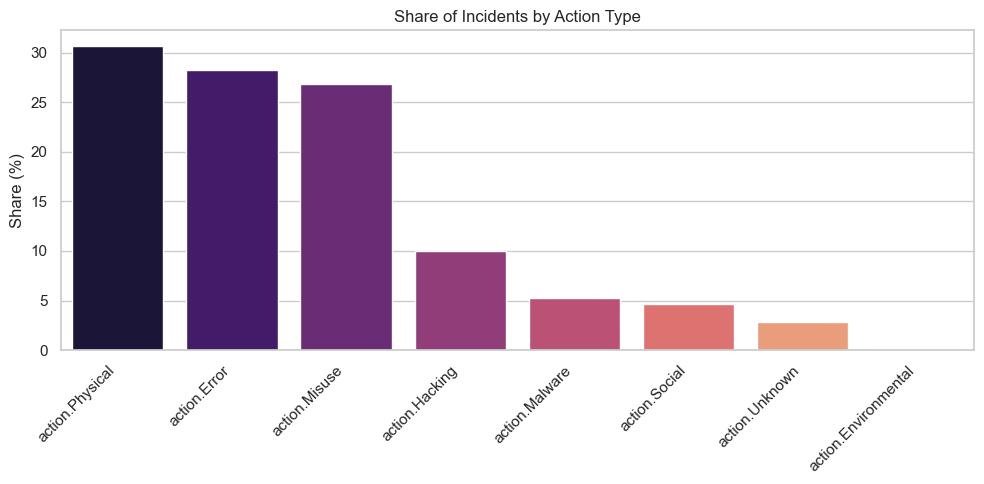

In [354]:
action_cols = [col for col in healthcare_df.columns if col.startswith('action.') and '.' not in col[len('action.'):]]
print(action_cols)
action_counts = healthcare_df[action_cols].sum().sort_values(ascending=False)
action_share = (action_counts / len(healthcare_df)) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=action_counts.index, y=action_counts.values, palette='viridis')
plt.title('Incident Count by Action Type')
plt.ylabel('Incident Count')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=action_share.index, y=action_share.values, palette='magma')
plt.title('Share of Incidents by Action Type')
plt.ylabel('Share (%)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


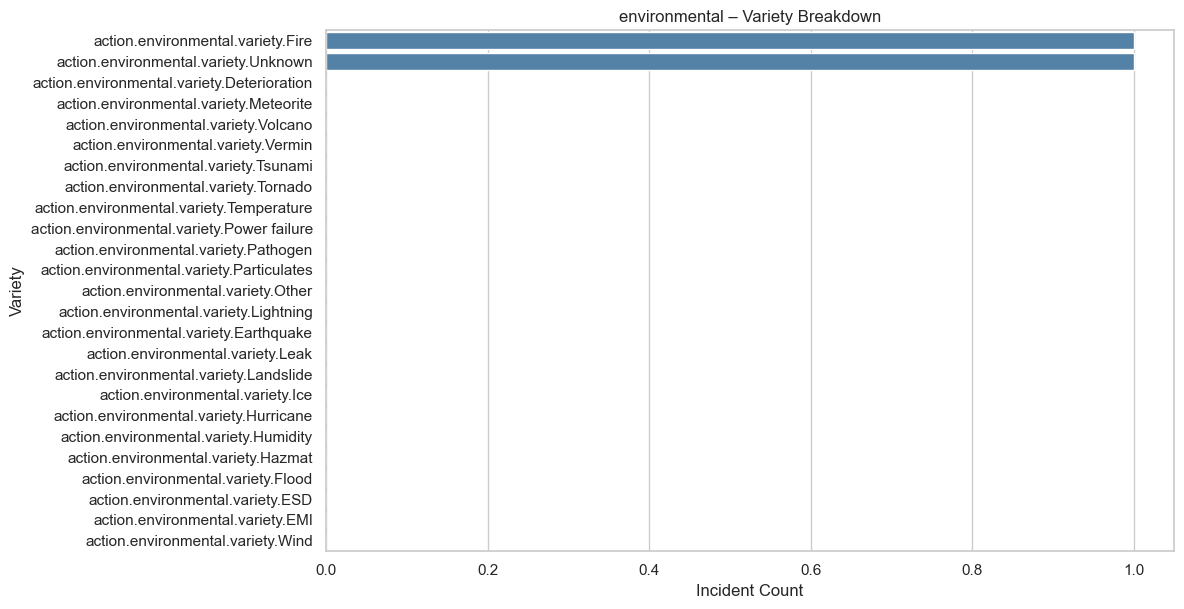

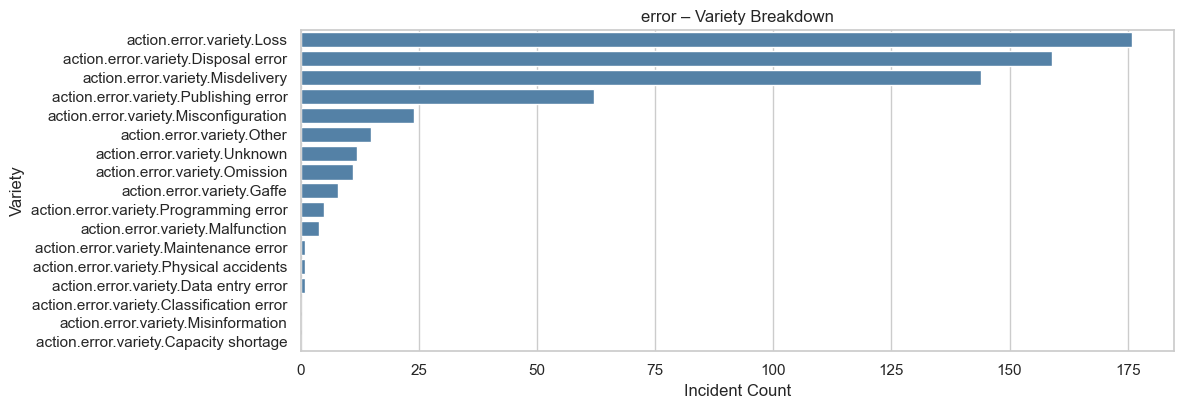

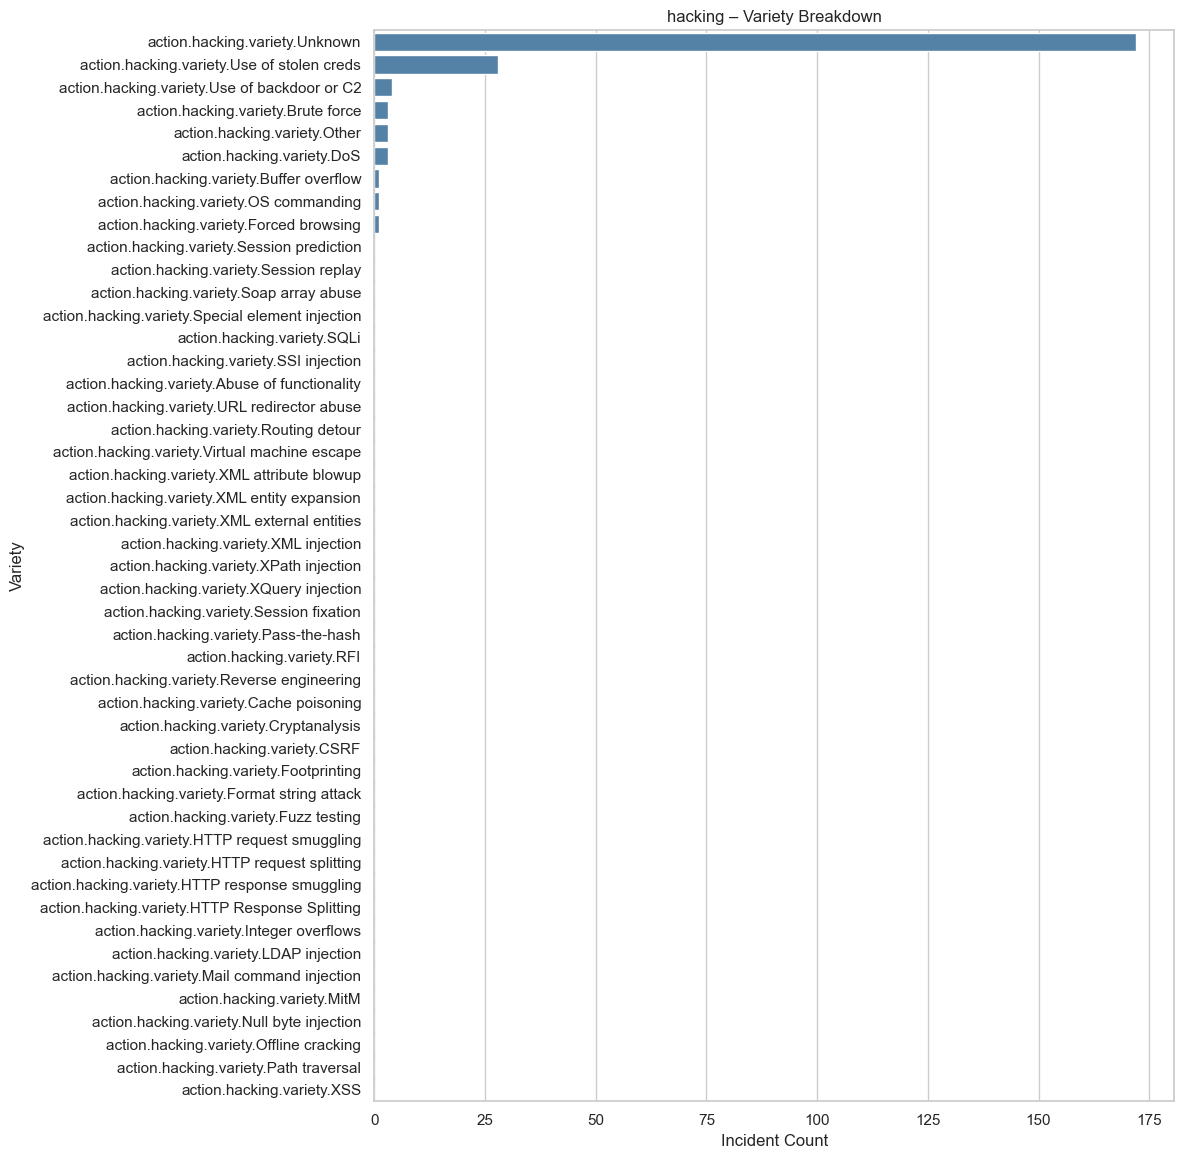

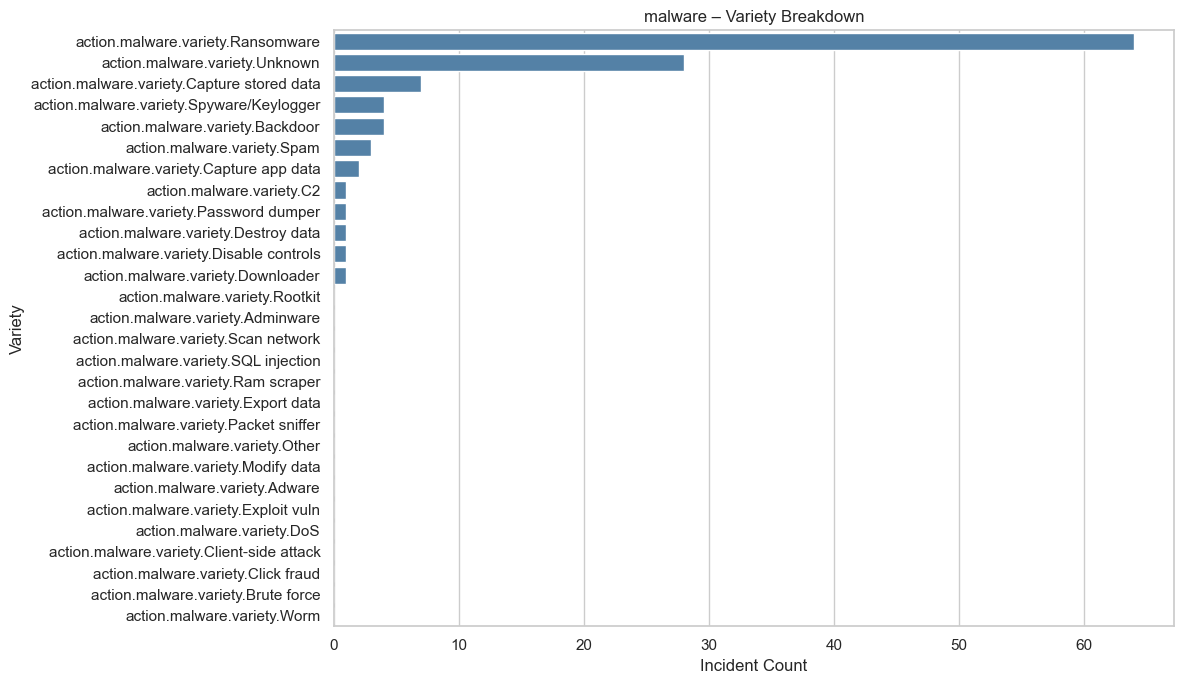

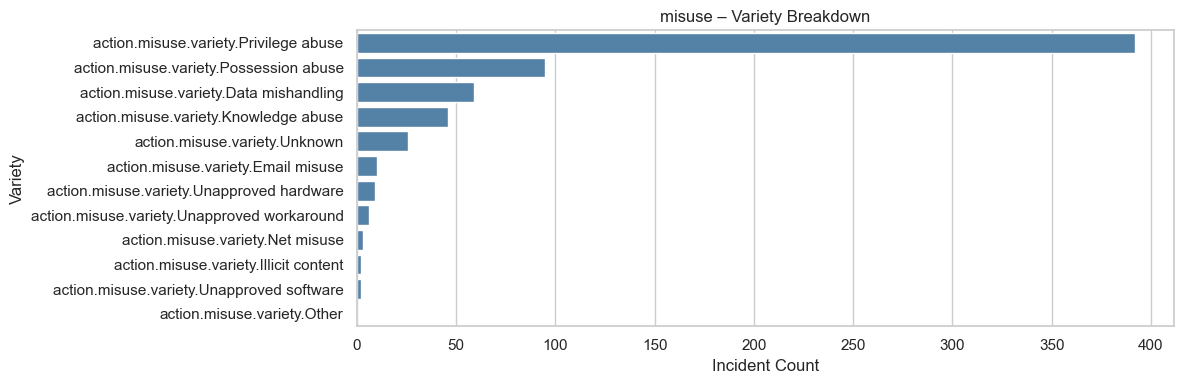

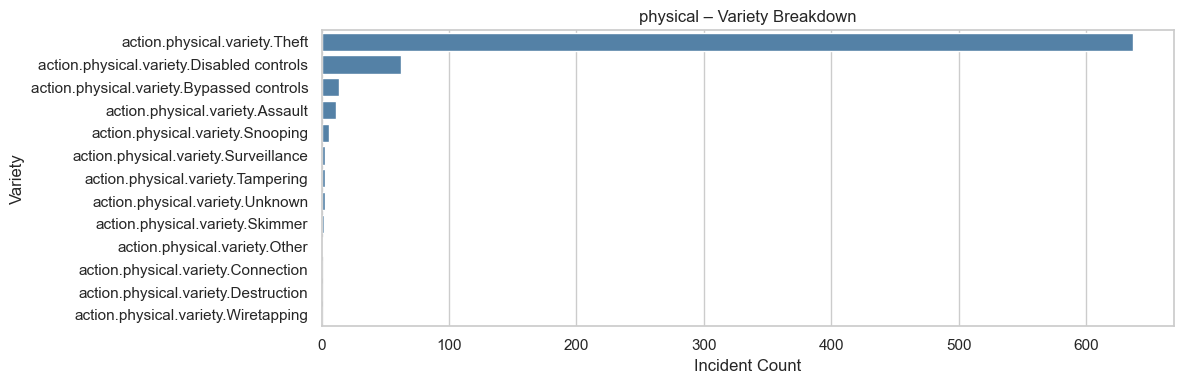

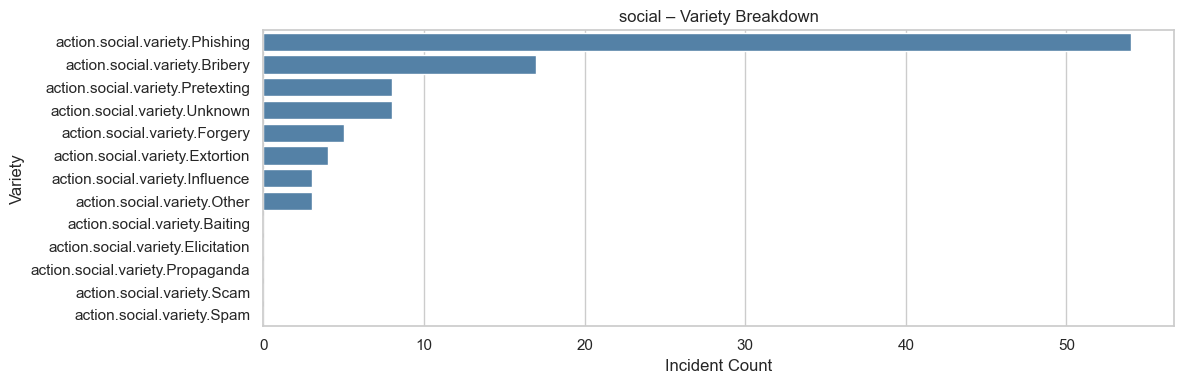

In [355]:
def plot_action_varieties(df):
    variety_groups = {}
    for col in df.columns:
      if col.startswith('action.') and '.variety.' in col:
          root = col.split('.', 2)[1] 
          variety_groups.setdefault(root, []).append(col)
    
    for root, columns in variety_groups.items():
      counts = (
          df[columns]
          .apply(pd.to_numeric, errors='coerce')
          .fillna(0)
          .sum()
          .sort_values(ascending=False)
          .reset_index()
      )
      counts.columns = ['variety', 'incident_count']
    
      plt.figure(figsize=(12, max(4, len(columns) * 0.25)))
      sns.barplot(
          data=counts,
          x='incident_count',
          y='variety',
          color='steelblue'
      )
      plt.title(f'{root} – Variety Breakdown')
      plt.xlabel('Incident Count')
      plt.ylabel('Variety')
      plt.tight_layout()
      plt.show()

plot_action_varieties(healthcare_df)



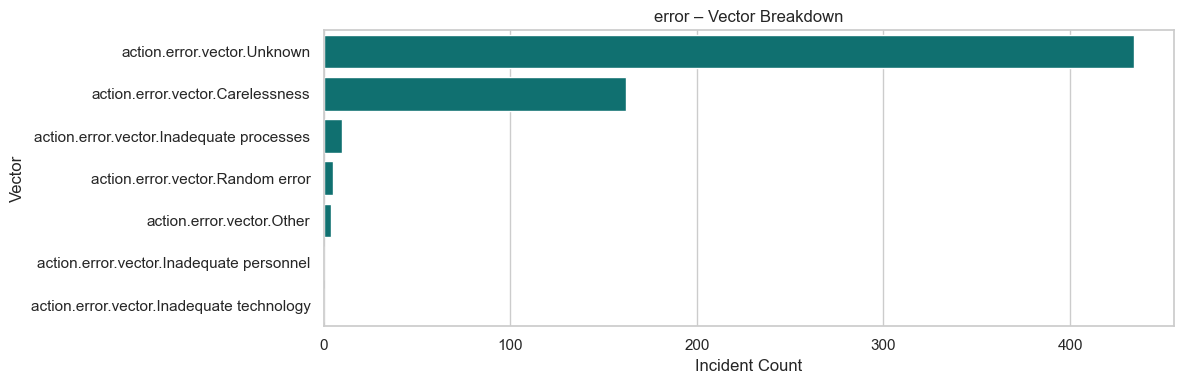

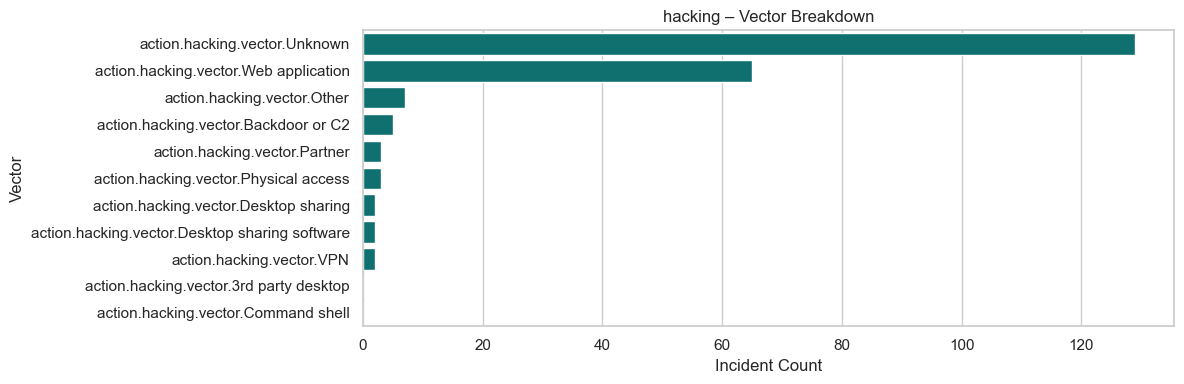

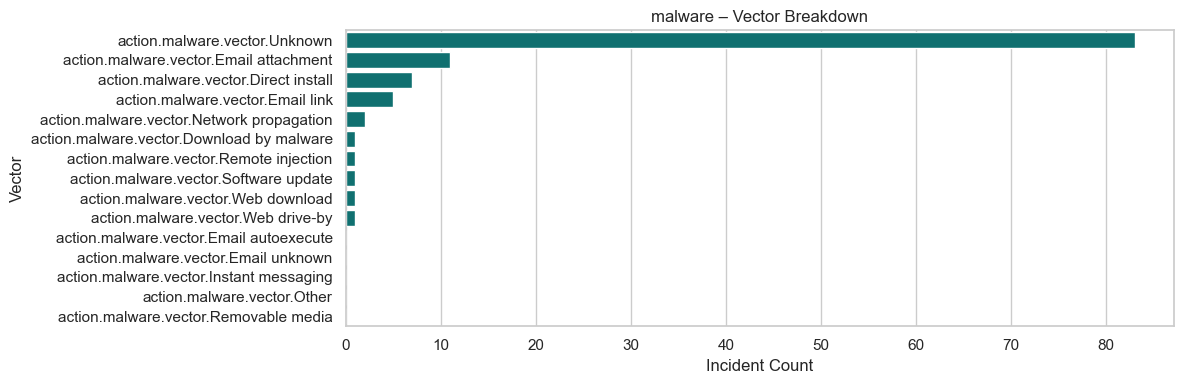

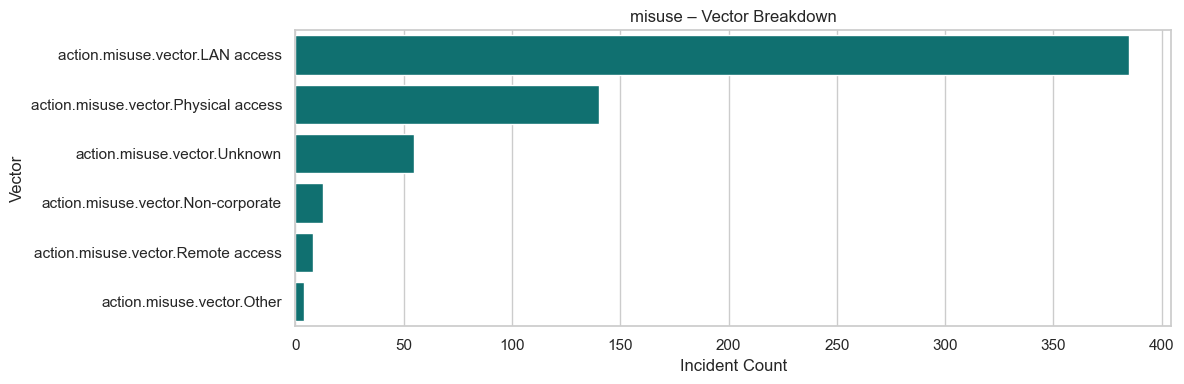

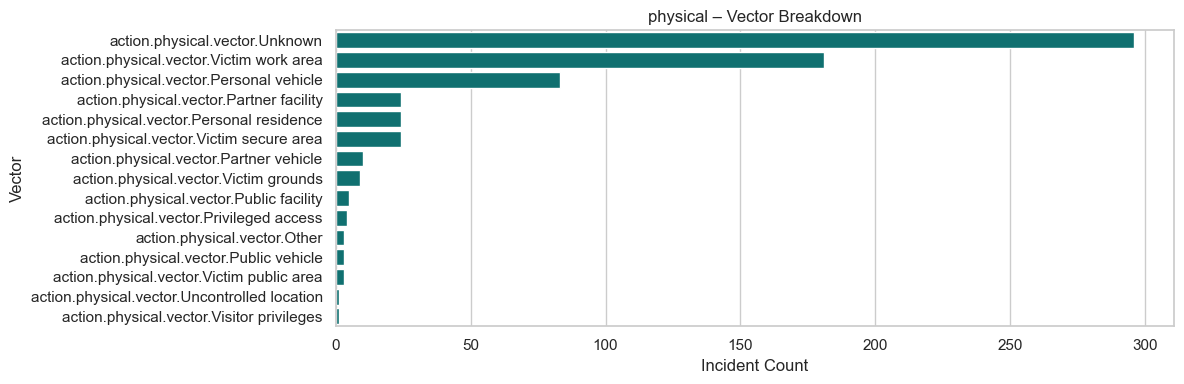

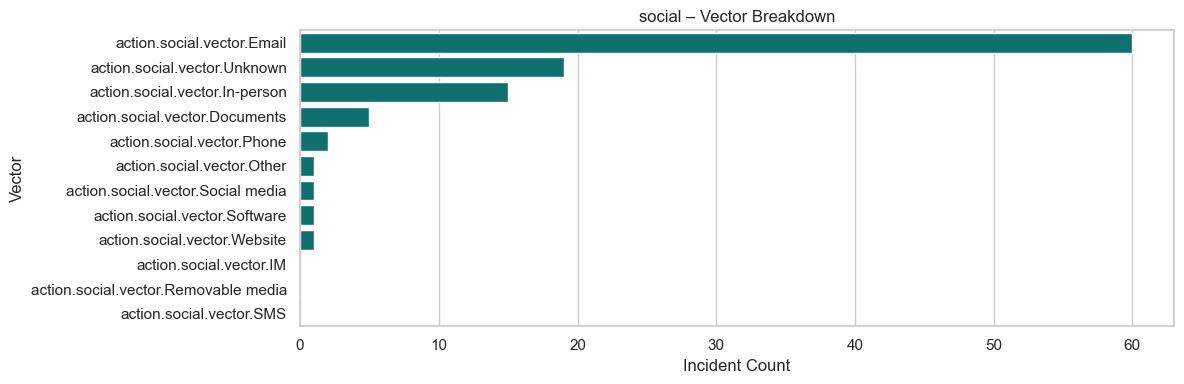

In [356]:
def plot_action_vectors(df):
  vector_groups = {}
  for col in df.columns:
      if col.startswith('action.') and '.vector.' in col:
          root = col.split('.', 2)[1]
          vector_groups.setdefault(root, []).append(col)

  for root, columns in vector_groups.items():
      counts = (
          df[columns]
          .apply(pd.to_numeric, errors='coerce')
          .fillna(0)
          .sum()
          .sort_values(ascending=False)
          .reset_index()
      )
      counts.columns = ['vector', 'incident_count']

      plt.figure(figsize=(12, max(4, len(columns) * 0.25)))
      sns.barplot(
          data=counts,
          x='incident_count',
          y='vector',
          color='teal'
      )
      plt.title(f'{root} – Vector Breakdown')
      plt.xlabel('Incident Count')
      plt.ylabel('Vector')
      plt.tight_layout()
      plt.show()

# Usage
plot_action_vectors(healthcare_df)

In [357]:
# Generate the loss amounts using multi-variate guassian distribution
model_cols = [
  'impact.loss.amount',
  'impact.overall_amount',
  'victim.revenue.amount'
]

model_df = healthcare_df[model_cols].copy()
model_df['impact.loss.amount'] = pd.to_numeric(model_df['impact.loss.amount'], errors='coerce')
model_df['impact.overall_amount'] = pd.to_numeric(model_df['impact.overall_amount'], errors='coerce').fillna(0)

train_df = model_df.dropna(subset=['impact.loss.amount'])
print(train_df.columns)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_df)

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(train_df)

missing_mask = model_df['impact.loss.amount'].isna()
generated = synthesizer.sample(num_rows=missing_mask.sum())
print(generated.head())

model_df.loc[missing_mask, 'impact.loss.amount'] = generated['impact.loss.amount'].values
healthcare_df['impact.loss.amount'] = model_df['impact.loss.amount']

Index(['impact.loss.amount', 'impact.overall_amount', 'victim.revenue.amount'], dtype='object')
   impact.loss.amount  impact.overall_amount  victim.revenue.amount
0           5902231.0              5902574.0            30000000000
1           4571780.0              4571128.0            30000000000
2           4508095.0              4508379.0            30000000000
3           4098430.0              4098247.0            30000000000
4           5753045.0              5752920.0            30000000000


/Users/rohit/Carnegie_Mellon/Fall2025/CRM/Project/venv/lib/python3.13/site-packages/sdv/single_table/base.py:168: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/Users/rohit/Carnegie_Mellon/Fall2025/CRM/Project/venv/lib/python3.13/site-packages/sdv/single_table/base.py:134: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [358]:
def redistribute_unknown_vectors(df, seed=42):
      rng = np.random.default_rng(seed)

      vector_cols = [c for c in df.columns if '.vector.' in c]
      action_vectors = defaultdict(list)
      for col in vector_cols:
          parts = col.split('.')
          if len(parts) < 3 or col.endswith('.Unknown'):
              continue
          action_token = parts[1].lower()  # e.g., 'malware', 'social'
          action_vectors[action_token].append(col)

      reassigned = 0
      for col in vector_cols:
          if not col.endswith('.Unknown'):
              continue

          parts = col.split('.')
          if len(parts) < 3:
              continue
          action_token = parts[1].lower()

          candidates = action_vectors.get(action_token)
          if not candidates:
              continue  # no known vectors for this action

          counts = df[candidates].apply(pd.to_numeric, errors='coerce').fillna(0).sum()
          total = counts.sum()
          if total == 0:
              continue

          probs = (counts / total).values
          unknown_flag = pd.to_numeric(df[col], errors='coerce').fillna(0)
          idx = df.index[unknown_flag == 1]
          if idx.empty:
              continue

          sampled = rng.choice(candidates, size=len(idx), p=probs)
          for row_idx, vec_col in zip(idx, sampled):
              df.at[row_idx, col] = 0
              df.at[row_idx, vec_col] = 1
              reassigned += 1

      print(f"Reassigned {reassigned} Unknown vector flags.")

redistribute_unknown_vectors(healthcare_df)

Reassigned 1016 Unknown vector flags.


,impact.loss.amount,impact.overall_amount
count,2.173000e+03,1.700000e+01
mean,4.626727e+06,9.346687e+05
std,1.104543e+06,1.673326e+06
min,2.700000e+06,2.500000e+02
50%,4.614231e+06,2.000000e+05
75%,5.583531e+06,1.000000e+06
90%,6.162973e+06,2.538000e+06
95%,6.335713e+06,3.460000e+06
max,6.500000e+06,6.500000e+06


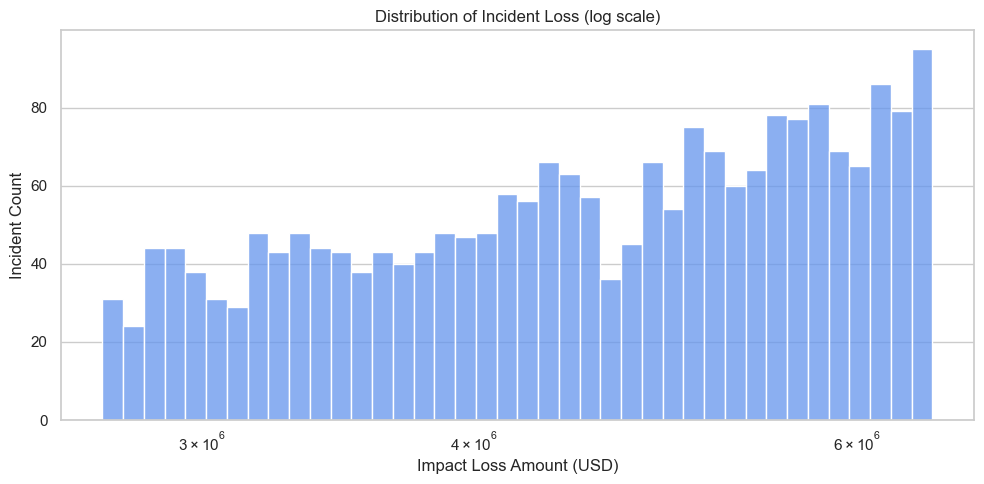

In [359]:
# Use the normalized healthcare dataset
loss_cols = ['impact.loss.amount', 'impact.overall_amount']
loss_df = healthcare_df[loss_cols].apply(pd.to_numeric, errors='coerce')

# Get the count, mean, std, min, max, 25th, median, and others
loss_summary = loss_df.describe(percentiles=[0.5, 0.75, 0.9, 0.95])
display(loss_summary)

plt.figure(figsize=(10, 5))
sns.histplot(loss_df['impact.loss.amount'].dropna(), bins=40, log_scale=True,
color='cornflowerblue')
plt.title('Distribution of Incident Loss (log scale)')
plt.xlabel('Impact Loss Amount (USD)')
plt.ylabel('Incident Count')
plt.tight_layout()
plt.show()

,count,median,mean
action,,,
Environmental,2,5543962.5,5.543962e+06
Social,102,4980913.0,4.757091e+06
Hacking,217,4765354.0,4.704731e+06
Malware,114,4750974.5,4.723175e+06
Physical,667,4730647.0,4.670887e+06
Misuse,582,4651969.5,4.627906e+06
Error,614,4509895.0,4.555551e+06
Unknown,61,4350857.0,4.499643e+06


/tmp/ipykernel_36409/3217752943.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




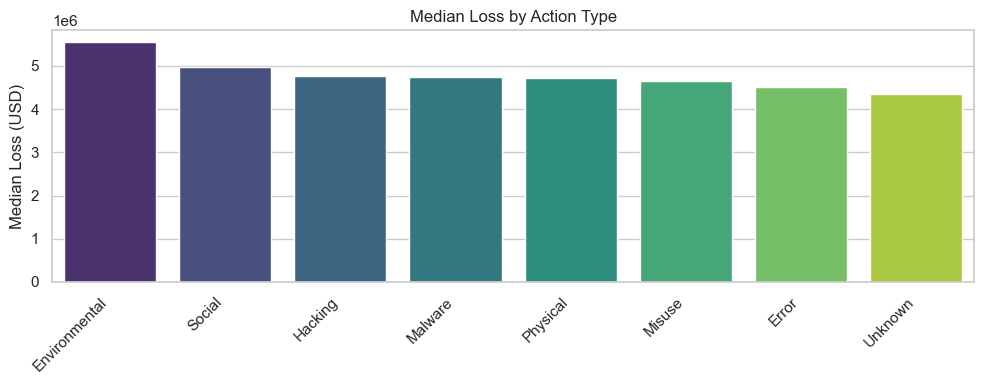

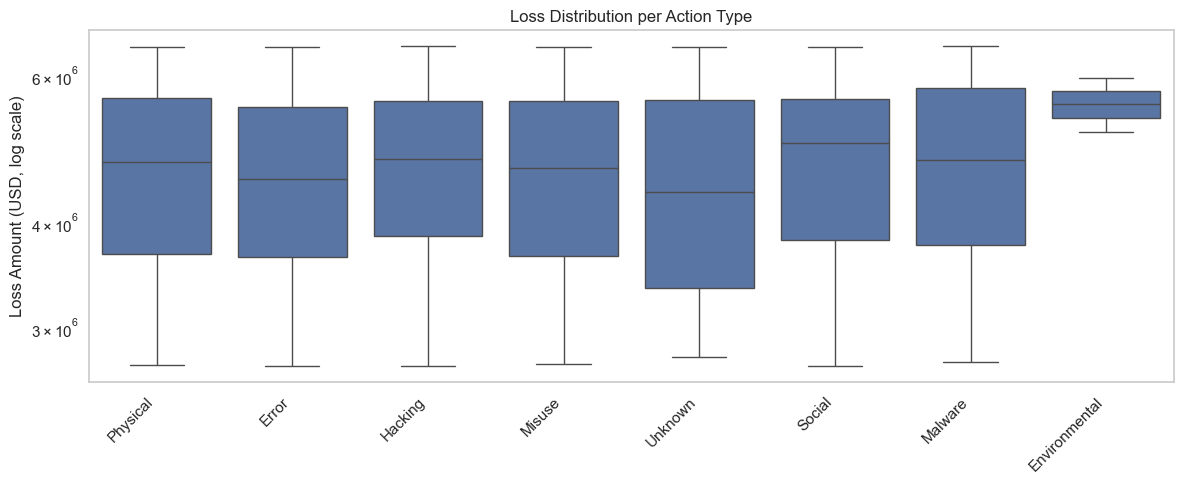

In [360]:
loss_col = 'impact.loss.amount'
action_cols = [c for c in healthcare_df.columns if c.startswith('action.') and c.count('.') == 1]

action_loss = []
for _, row in healthcare_df[action_cols + [loss_col]].iterrows():
  loss = row[loss_col]
  if pd.isna(loss):
      continue
  for action_col in action_cols:
      if row[action_col] == 1:
          action_loss.append({'action': action_col.replace('action.', ''), 'loss':loss})

action_loss_df = pd.DataFrame(action_loss)

# Summary stats per action
summary = action_loss_df.groupby('action')['loss'].agg(['count', 'median', 'mean'])
display(summary.sort_values('median', ascending=False))

# Visualizations
plt.figure(figsize=(10, 4))
sns.barplot(
  data=summary.reset_index().sort_values('median', ascending=False),
  x='action', y='median', palette='viridis'
)
plt.title('Median Loss by Action Type')
plt.ylabel('Median Loss (USD)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=action_loss_df, x='action', y='loss')
plt.yscale('log')
plt.title('Loss Distribution per Action Type')
plt.xlabel('')
plt.ylabel('Loss Amount (USD, log scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

,vector,incident_count,total_loss,avg_loss
action.error.vector.Carelessness,Carelessness,552,2.518463e+09,4562433.601449
action.misuse.vector.LAN access,LAN access,425,1.974843e+09,4646688.809412
action.physical.vector.Victim work area,Victim work area,318,1.480521e+09,4655726.455975
action.hacking.vector.Web application,Web application,158,7.332482e+08,4640811.613924
action.misuse.vector.Physical access,Physical access,151,6.925220e+08,4586238.602649
...,...,...,...,...
action.hacking.vector.Unknown,Unknown,0,0.000000e+00,<NA>
action.error.vector.Inadequate personnel,Inadequate personnel,0,0.000000e+00,<NA>
action.error.vector.Unknown,Unknown,0,0.000000e+00,<NA>
action.malware.vector.Removable media,Removable media,0,0.000000e+00,<NA>


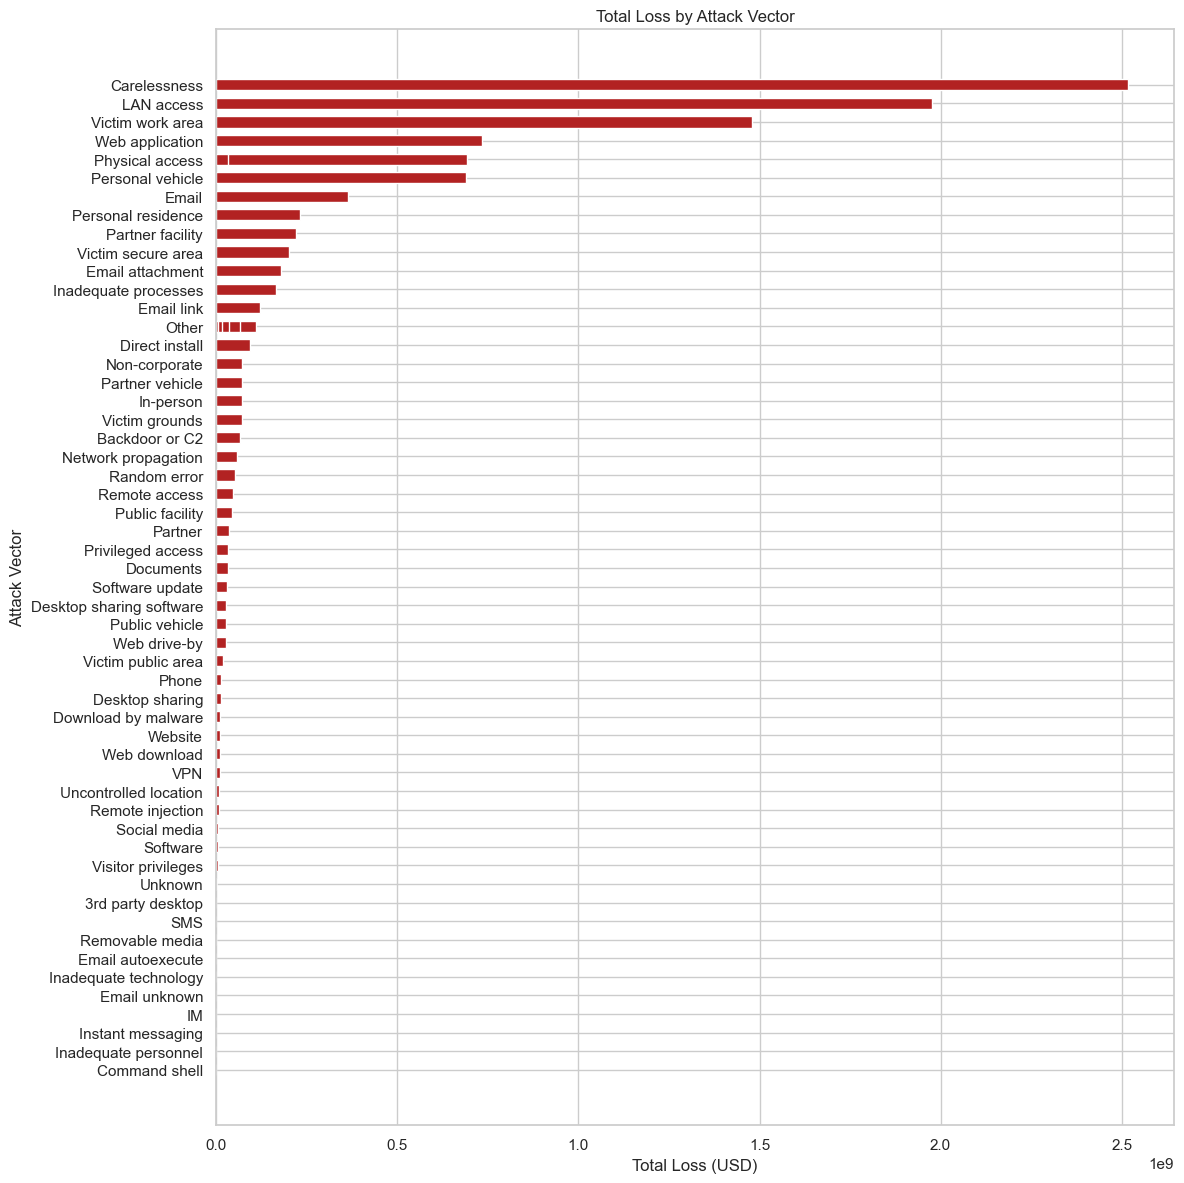

In [361]:
loss_col = 'impact.loss.amount'
loss_series = pd.to_numeric(healthcare_df[loss_col], errors='coerce').fillna(0)

vector_cols = [c for c in healthcare_df.columns if '.vector.' in c]
vector_flags = healthcare_df[vector_cols].apply(pd.to_numeric,
errors='coerce').fillna(0)

vector_stats = pd.DataFrame({
  'vector': [col.split('.vector.', 1)[1] for col in vector_cols],
  'incident_count': vector_flags.sum().astype(int),
  'total_loss': vector_flags.mul(loss_series, axis=0).sum()
})
vector_stats['avg_loss'] = vector_stats['total_loss'] / vector_stats['incident_count'].replace(0, pd.NA)
vector_stats = vector_stats.sort_values('total_loss', ascending=False)

display(vector_stats)

plt.figure(figsize=(12, 12))
bars = plt.barh(
  y=vector_stats['vector'],
  width=vector_stats['total_loss'],
  height=0.6,
  color='firebrick'
)
plt.title('Total Loss by Attack Vector')
plt.xlabel('Total Loss (USD)')
plt.ylabel('Attack Vector')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


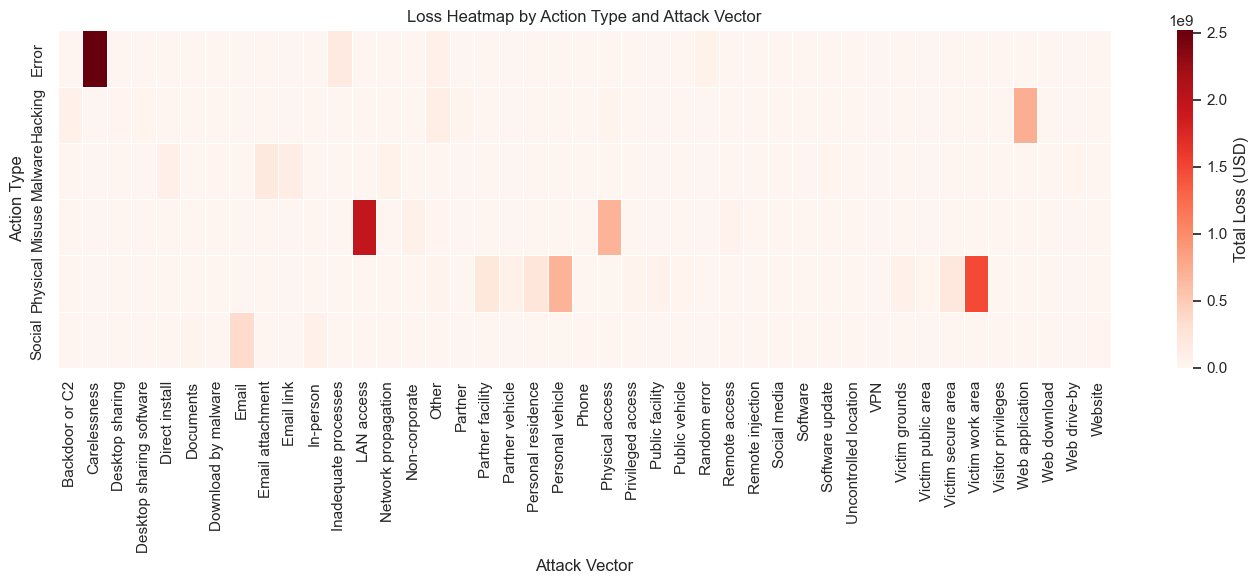

In [362]:
loss = pd.to_numeric(healthcare_df['impact.loss.amount'], errors='coerce').fillna(0)

# Identify top-level action flags (e.g., action.Malware) and the corresponding vector columns
action_cols = [c for c in healthcare_df.columns if c.startswith('action.') and c.count('.') == 1]
vector_cols = [c for c in healthcare_df.columns if '.vector.' in c]

records = []
for action_col in action_cols:
    action_name = action_col.replace('action.', '')
    action_flag = pd.to_numeric(healthcare_df[action_col], errors='coerce').fillna(0)
    
    for vector_col in vector_cols:
        root = vector_col.split('.', 2)[1]
        if root.lower() != action_name.lower():
            continue
        vector_name = vector_col.split('.vector.', 1)[1]
        vector_flag = pd.to_numeric(healthcare_df[vector_col], errors='coerce').fillna(0)
        mask = (action_flag == 1) & (vector_flag == 1)
        total_loss = loss[mask].sum()
        if total_loss > 0:
            records.append({'action': action_name, 'vector': vector_name, 'total_loss': total_loss})

matrix_df = pd.DataFrame(records).pivot_table(
  index='action', columns='vector', values='total_loss', aggfunc='sum',
fill_value=0
)

plt.figure(figsize=(14, 6))
sns.heatmap(
  matrix_df,
  cmap='Reds',
  linewidths=0.5,
  linecolor='white',
  cbar_kws={'label': 'Total Loss (USD)'}
)
plt.title('Loss Heatmap by Action Type and Attack Vector')
plt.xlabel('Attack Vector')
plt.ylabel('Action Type')
plt.tight_layout()
plt.show()

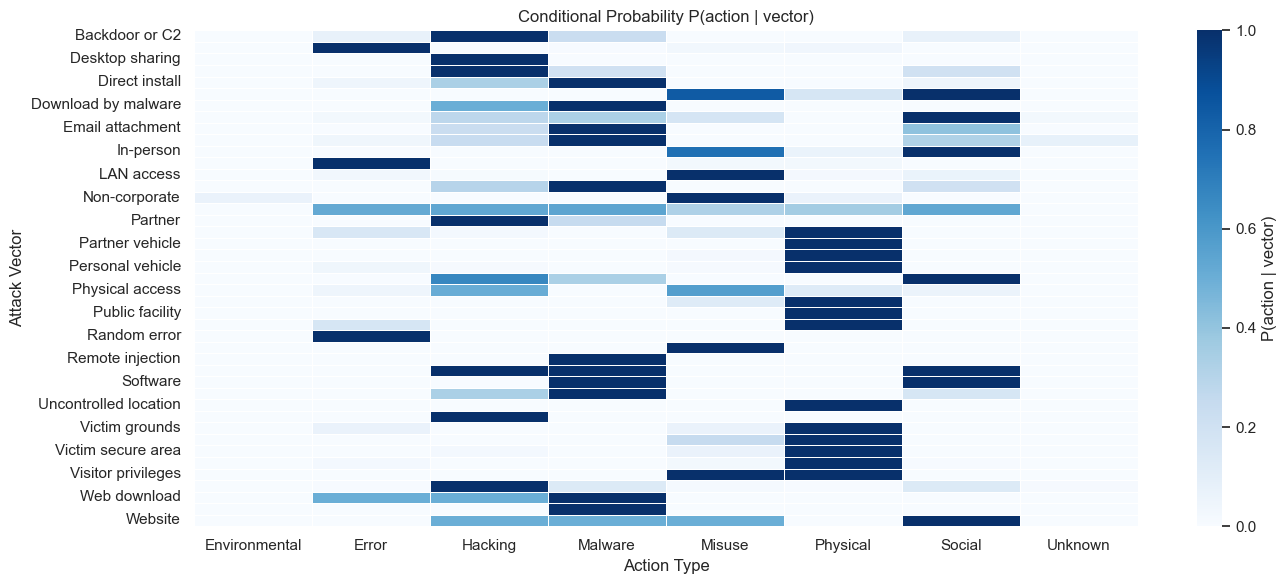

In [363]:
loss_series = pd.to_numeric(healthcare_df['impact.loss.amount'], errors='coerce').fillna(0)
action_cols = [c for c in healthcare_df.columns if c.startswith('action.') and c.count('.') == 1]
vector_cols = [c for c in healthcare_df.columns if '.vector.' in c and c.count('.') >= 3]

vector_action_records = []
for vector_col in vector_cols:
    _, action_name, *_ = vector_col.split('.')
    vector_name = vector_col.split('.vector.', 1)[1]
    vector_flag = pd.to_numeric(healthcare_df[vector_col], errors='coerce').fillna(0)
    for action_col in action_cols:
        action_flag = pd.to_numeric(healthcare_df[action_col], errors='coerce').fillna(0)
        matching = ((vector_flag == 1) & (action_flag == 1)).sum()
        total_vector = (vector_flag == 1).sum()
        if total_vector == 0:
            continue
        prob = matching / total_vector
        vector_action_records.append({
            'vector': vector_name,
            'action': action_col.replace('action.', ''),
            'probability': prob,
            'matching_incidents': matching,
            'total_vector_incidents': total_vector,
        })

vector_action_df = pd.DataFrame(vector_action_records)
vector_action_df = vector_action_df[vector_action_df['probability'] > 0]
vector_action_df.sort_values(['vector', 'probability'], ascending=[True, False], inplace=True)
vector_action_df.head(20)

pivot_prob = vector_action_df.pivot_table(index='vector', columns='action', values='probability', fill_value=0)
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_prob, cmap='Blues', linewidths=0.5, linecolor='white', cbar_kws={'label': 'P(action | vector)'})
plt.title('Conditional Probability P(action | vector)')
plt.xlabel('Action Type')
plt.ylabel('Attack Vector')
plt.tight_layout()
plt.show()


,action,likelihood,median_impact,p90_impact,incident_count
3,Physical,0.306949,4730647.0,6175161.4,667
5,Error,0.282559,4509895.0,6071761.7,614
4,Misuse,0.267832,4651969.5,6184493.5,582
1,Hacking,0.099862,4765354.0,6157916.6,217
0,Malware,0.052462,4750974.5,6222386.2,114
2,Social,0.046940,4980913.0,6115067.6,102
7,Unknown,0.028072,4350857.0,6196024.0,61
6,Environmental,0.000920,5543962.5,5871728.5,2


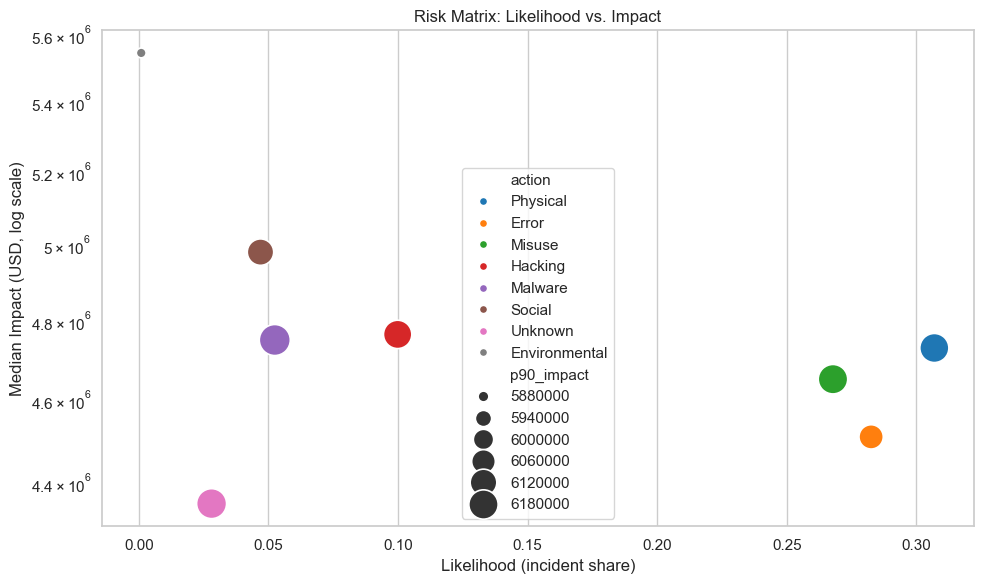

In [364]:
loss_col = 'impact.loss.amount'
loss_values = pd.to_numeric(healthcare_df[loss_col], errors='coerce').fillna(0)
action_cols = [c for c in healthcare_df.columns if c.startswith('action.') and c.count('.') == 1]

risk_records = []
total_incidents = len(healthcare_df)

for action_col in action_cols:
  action_name = action_col.replace('action.', '')
  flags = pd.to_numeric(healthcare_df[action_col], errors='coerce').fillna(0)
  count = (flags == 1).sum()
  if count == 0:
      continue

  likelihood = count / total_incidents
  impact_values = loss_values[flags == 1]
  median_impact = impact_values.median()
  p90_impact = impact_values.quantile(0.9)

  risk_records.append({
      'action': action_name,
      'likelihood': likelihood,
      'median_impact': median_impact,
      'p90_impact': p90_impact,
      'incident_count': count,
  })

risk_df = pd.DataFrame(risk_records).sort_values('likelihood', ascending=False)
display(risk_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(
  data=risk_df,
  x='likelihood',
  y='median_impact',
  size='p90_impact',
  sizes=(50, 500),
  hue='action',
  palette='tab10',
)
plt.yscale('log')
plt.title('Risk Matrix: Likelihood vs. Impact')
plt.xlabel('Likelihood (incident share)')
plt.ylabel('Median Impact (USD, log scale)')
plt.tight_layout()
plt.show()

,year,count,sum,median,mean
0,1994.0,1,5.033774e+06,5033774.0,5.033774e+06
1,2001.0,1,2.757271e+06,2757271.0,2.757271e+06
2,2002.0,1,5.817034e+06,5817034.0,5.817034e+06
3,2003.0,4,2.176974e+07,5697464.0,5.442434e+06
4,2004.0,3,1.349605e+07,4469206.0,4.498684e+06
5,2005.0,4,1.999544e+07,4996082.5,4.998861e+06
6,2006.0,4,1.929444e+07,4818724.0,4.823609e+06
7,2007.0,9,4.124090e+07,4147807.0,4.582322e+06
8,2008.0,17,7.330202e+07,4150742.0,4.311884e+06
9,2009.0,27,1.166526e+08,3663574.0,4.320465e+06


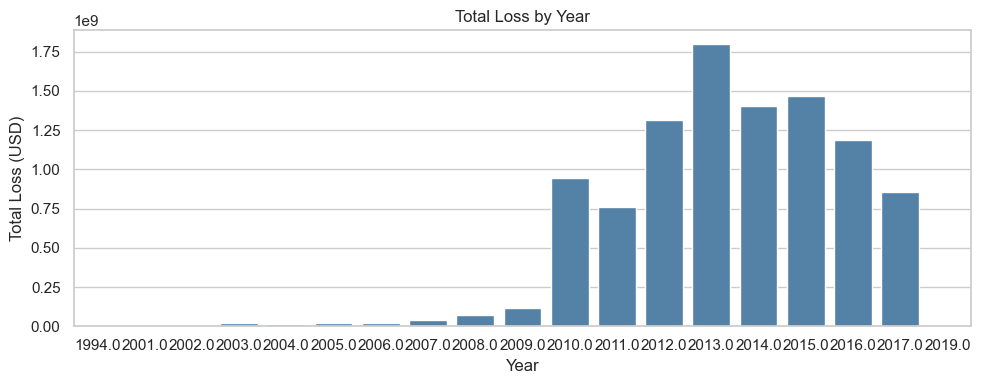

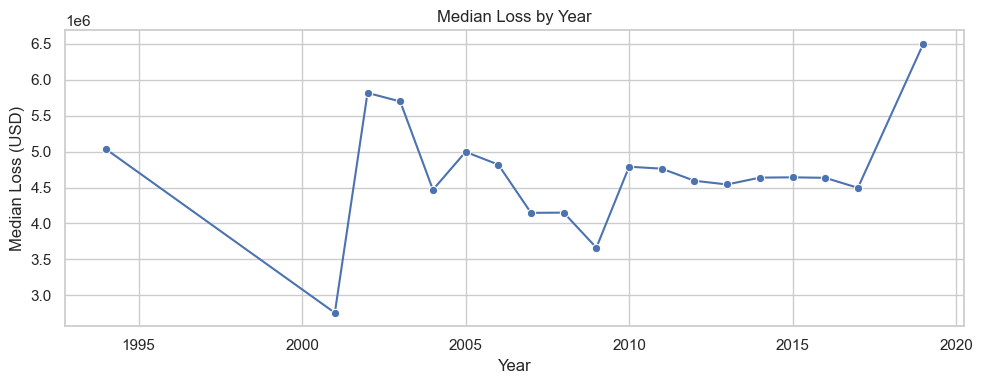

In [365]:
year_col = 'timeline.incident.year'
trend_df = (
  healthcare_df[[year_col, 'impact.loss.amount']]
  .assign(
      year=lambda df: pd.to_numeric(df[year_col], errors='coerce'),
      loss=lambda df: pd.to_numeric(df['impact.loss.amount'], errors='coerce').fillna(0)
  )
  .dropna(subset=['year'])
)

trend_summary = trend_df.groupby('year')['loss'].agg(['count', 'sum', 'median', 'mean']).reset_index()
display(trend_summary)

plt.figure(figsize=(10, 4))
sns.barplot(data=trend_summary, x='year', y='sum', color='steelblue')
plt.title('Total Loss by Year')
plt.xlabel('Year')
plt.ylabel('Total Loss (USD)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(data=trend_summary, x='year', y='median', marker='o')
plt.title('Median Loss by Year')
plt.xlabel('Year')
plt.ylabel('Median Loss (USD)')
plt.tight_layout()
plt.show()

,asset,incident_count,total_loss,avg_loss
0,Server,758,3.501368e+09,4.619219e+06
3,Media,719,3.307436e+09,4.600050e+06
2,User Dev,577,2.668315e+09,4.624462e+06
6,Unknown,140,6.607157e+08,4.719398e+06
4,Person,117,5.588525e+08,4.776517e+06
1,Network,8,4.401842e+07,5.502303e+06
5,Kiosk/Term,3,1.539046e+07,5.130153e+06


/tmp/ipykernel_36409/3489470755.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




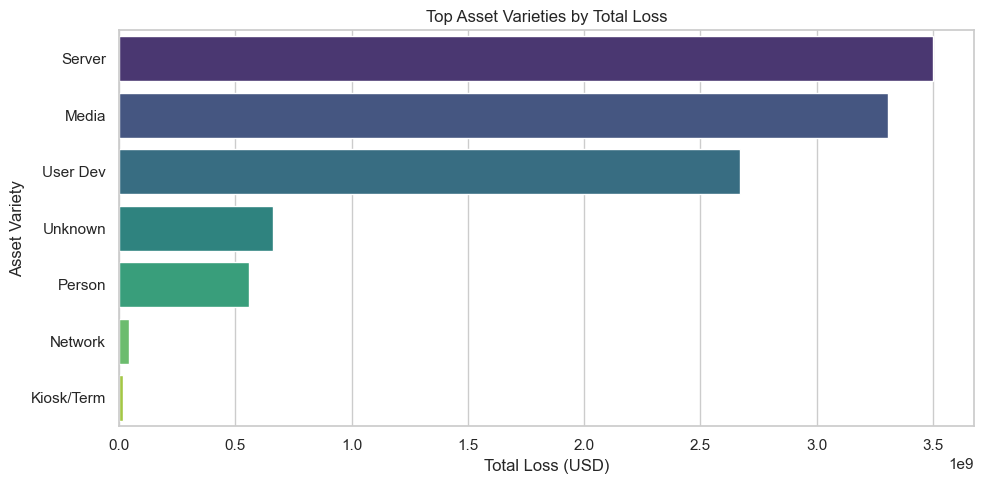

In [367]:
asset_cols = [c for c in healthcare_df.columns if c.startswith('asset.variety.')]
loss_vals = pd.to_numeric(healthcare_df['impact.loss.amount'], errors='coerce').fillna(0)

records = []
for col in asset_cols:
  asset = col.replace('asset.variety.', '')
  flags = pd.to_numeric(healthcare_df[col], errors='coerce').fillna(0)
  incident_count = (flags == 1).sum()
  if incident_count == 0:
      continue
  total_loss = loss_vals[flags == 1].sum()
  avg_loss = loss_vals[flags == 1].mean()
  records.append({
      'asset': asset,
      'incident_count': incident_count,
      'total_loss': total_loss,
      'avg_loss': avg_loss,
  })

asset_df = pd.DataFrame(records).sort_values('total_loss', ascending=False)
display(asset_df.head(10))

plt.figure(figsize=(10, 5))
sns.barplot(data=asset_df.head(10), x='total_loss', y='asset', palette='viridis')
plt.title('Top Asset Varieties by Total Loss')
plt.xlabel('Total Loss (USD)')
plt.ylabel('Asset Variety')
plt.tight_layout()
plt.show()

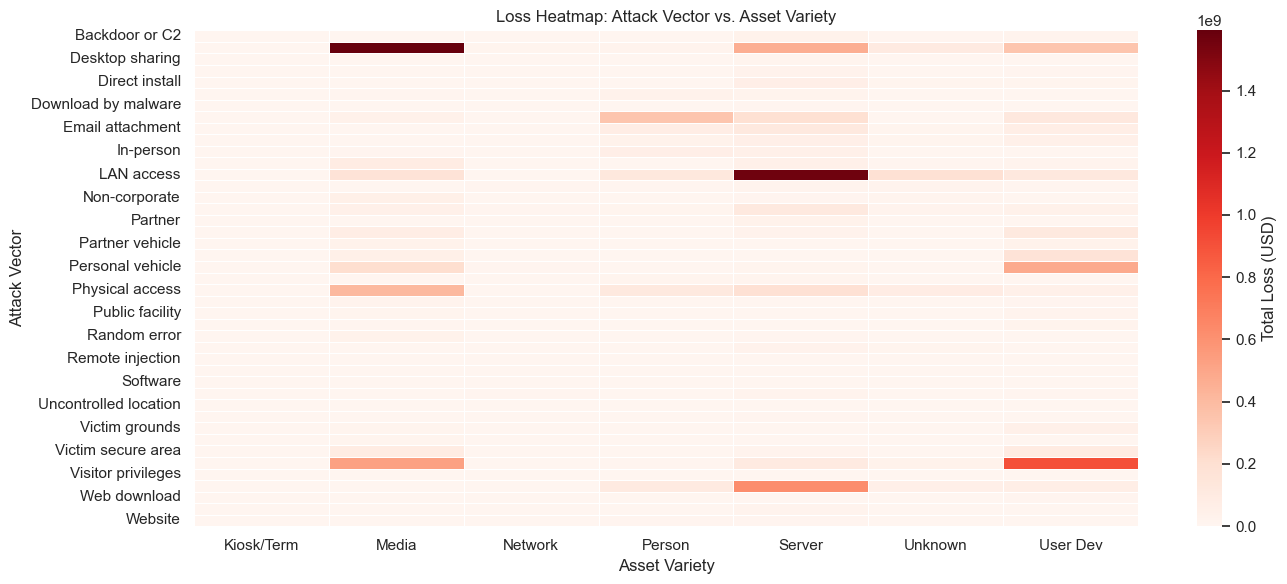

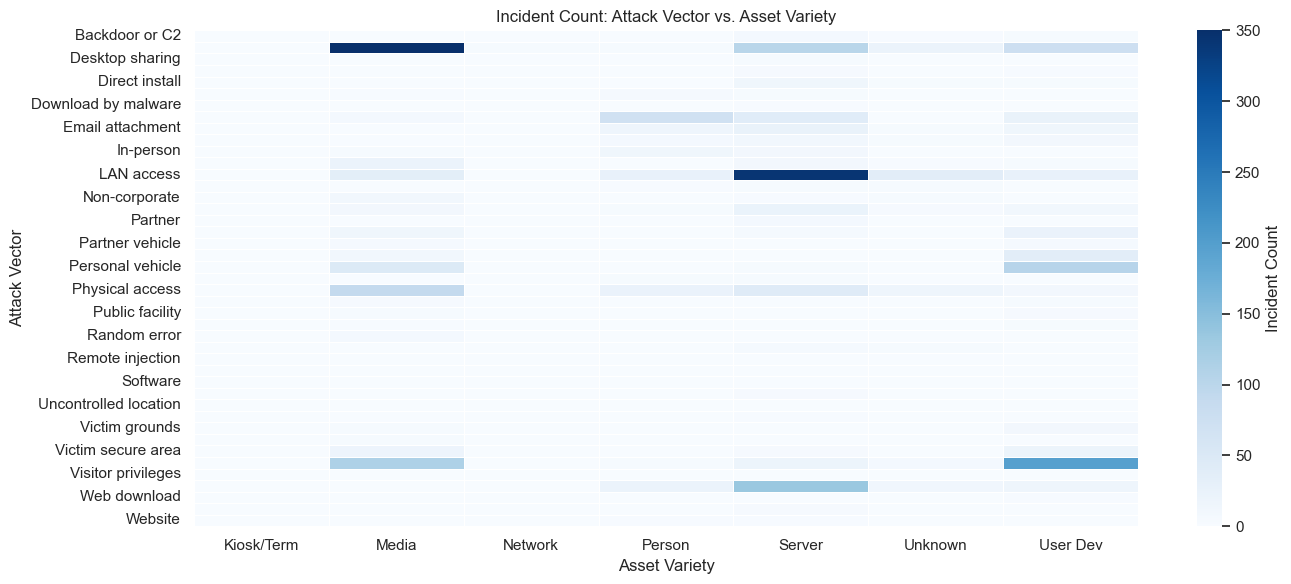

In [371]:
vector_cols = [c for c in healthcare_df.columns if '.vector.' in c]
asset_cols = [c for c in healthcare_df.columns if c.startswith('asset.variety.')]
loss_vals = pd.to_numeric(healthcare_df['impact.loss.amount'], errors='coerce').fillna(0)

records = []
for vector_col in vector_cols:
  vector_name = vector_col.split('.vector.', 1)[1]
  vector_flags = pd.to_numeric(healthcare_df[vector_col], errors='coerce').fillna(0)
  if vector_flags.sum() == 0:
      continue
  for asset_col in asset_cols:
      asset_name = asset_col.replace('asset.variety.', '')
      asset_flags = pd.to_numeric(healthcare_df[asset_col], errors='coerce').fillna(0)
      mask = (vector_flags == 1) & (asset_flags == 1)
      if mask.sum() == 0:
          continue
      total_loss = loss_vals[mask].sum()
      records.append({
          'vector': vector_name,
          'asset': asset_name,
          'total_loss': total_loss,
          'incident_count': mask.sum(),
      })

matrix_df = pd.DataFrame(records)

pivot_loss = matrix_df.pivot_table(index='vector', columns='asset', values='total_loss', aggfunc='sum', fill_value=0)
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_loss, cmap='Reds', linewidths=0.5, linecolor='white', cbar_kws={'label': 'Total Loss (USD)'})
plt.title('Loss Heatmap: Attack Vector vs. Asset Variety')
plt.xlabel('Asset Variety')
plt.ylabel('Attack Vector')
plt.tight_layout()
plt.show()

pivot_count = matrix_df.pivot_table(index='vector', columns='asset', values='incident_count', aggfunc='sum', fill_value=0)
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_count, cmap='Blues', linewidths=0.5, linecolor='white', cbar_kws={'label': 'Incident Count'})
plt.title('Incident Count: Attack Vector vs. Asset Variety')
plt.xlabel('Asset Variety')
plt.ylabel('Attack Vector')
plt.tight_layout()
plt.show()

year
2013.0     1
2014.0     8
2015.0     8
2016.0    17
2017.0    20
Name: count, dtype: int64

year
2013.0    0.018519
2014.0    0.148148
2015.0    0.148148
2016.0    0.314815
2017.0    0.370370
Name: count, dtype: float64

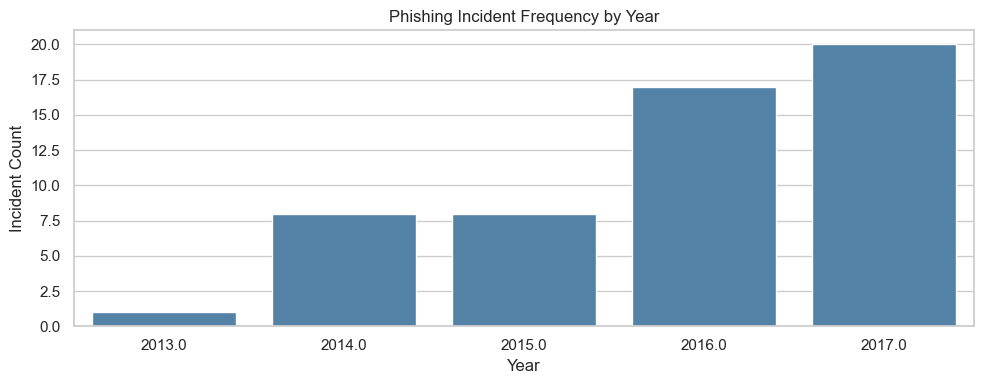

In [375]:
phishing_col = 'action.social.variety.Phishing'

phish_df = healthcare_df[
  pd.to_numeric(healthcare_df[phishing_col], errors='coerce').fillna(0) == 1
].copy()
phish_df['year'] = pd.to_numeric(healthcare_df['timeline.incident.year'], errors='coerce')

frequency_counts = (
  phish_df
  .dropna(subset=['year'])
  .groupby('year')
  .size()
  .rename('count')
)
display(frequency_counts)

frequency_prob = frequency_counts / frequency_counts.sum()
display(frequency_prob)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequency_counts.index, y=frequency_counts.values, color='steelblue')
plt.title('Phishing Incident Frequency by Year')
plt.xlabel('Year')
plt.ylabel('Incident Count')
plt.tight_layout()
plt.show()

1     1
8     2
17    1
20    1
Name: years_with_n_incidents, dtype: int64

1     0.2
8     0.4
17    0.2
20    0.2
Name: probability_of_n_incidents, dtype: float64

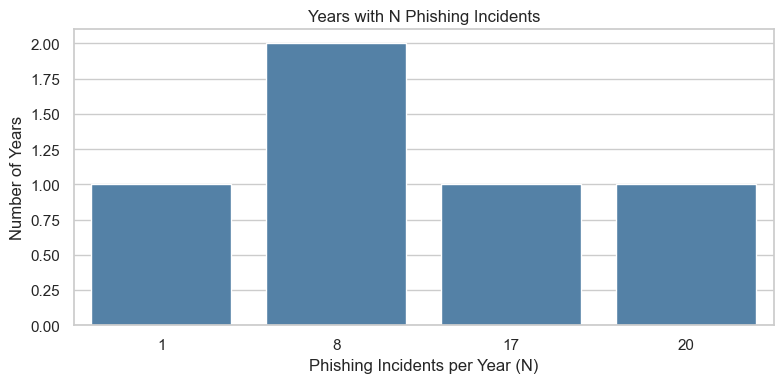

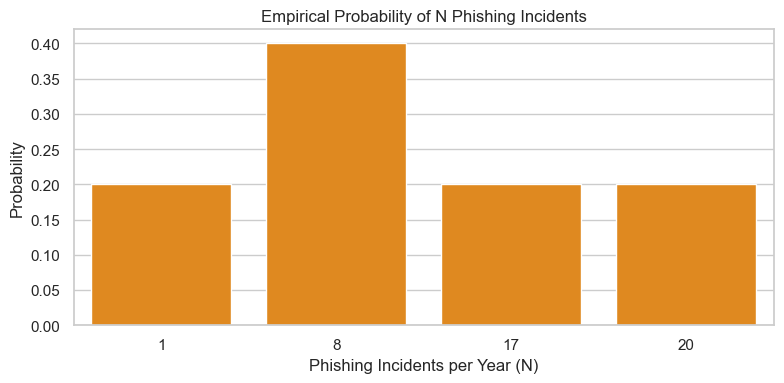

In [376]:
phish_df['year'] = pd.to_numeric(healthcare_df['timeline.incident.year'], errors='coerce')

# Count phishing incidents per year
year_counts = (
phish_df
.dropna(subset=['year'])
.groupby('year')
.size()
)

# Distribution over counts (how many years saw N incidents)
count_distribution = year_counts.value_counts().sort_index()
count_prob = count_distribution / count_distribution.sum()

display(count_distribution.rename('years_with_n_incidents'))
display(count_prob.rename('probability_of_n_incidents'))

plt.figure(figsize=(8, 4))
sns.barplot(x=count_distribution.index, y=count_distribution.values, color='steelblue')
plt.title('Years with N Phishing Incidents')
plt.xlabel('Phishing Incidents per Year (N)')
plt.ylabel('Number of Years')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=count_prob.index, y=count_prob.values, color='darkorange')
plt.title('Empirical Probability of N Phishing Incidents')
plt.xlabel('Phishing Incidents per Year (N)')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()



In [387]:
from scipy.stats import poisson, lognorm

# Fit Poisson to annual phishing incident counts
phishing_col = 'action.social.variety.Phishing'
phish_mask = pd.to_numeric(healthcare_df[phishing_col], errors='coerce').fillna(0) == 1
phish_years = pd.to_numeric(healthcare_df.loc[phish_mask, 'timeline.incident.year'], errors='coerce').dropna()

year_counts = phish_years.value_counts()
lam = year_counts.mean()

# Fit lognormal to phishing loss severities
phish_losses = pd.to_numeric(
  healthcare_df.loc[phish_mask, 'impact.loss.amount'], errors='coerce'
).dropna()
shape, loc, scale = lognorm.fit(phish_losses, floc=0)

# Monte Carlo simulation
trials = 1000
annual_losses = []
for _ in range(trials):
  incidents = poisson(mu=lam).rvs()
  if incidents == 0:
      annual_losses.append(0)
      continue
  severity_samples = lognorm(s=shape, scale=scale).rvs(size=incidents)
  annual_losses.append(severity_samples.sum())

annual_losses = np.array(annual_losses)
summary = pd.Series(annual_losses).describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
print(summary)


count    1.000000e+03
mean     5.112121e+07
std      1.596428e+07
min      8.916254e+06
50%      5.075338e+07
75%      6.106381e+07
90%      7.212208e+07
95%      7.863905e+07
99%      9.152901e+07
max      1.035396e+08
dtype: float64


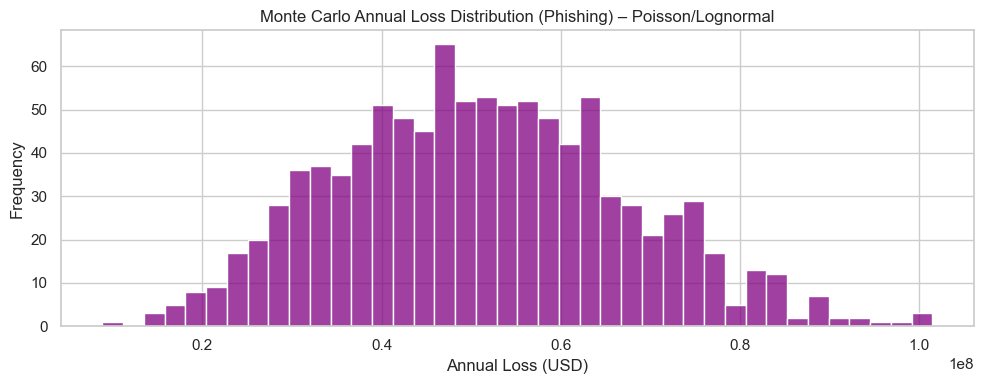

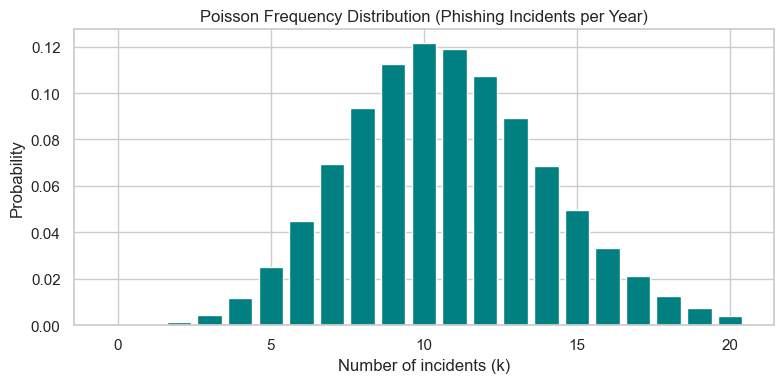

In [402]:
plt.figure(figsize=(10, 4))
sns.histplot(annual_losses, bins=40, color='purple')
plt.title('Monte Carlo Annual Loss Distribution (Phishing) – Poisson/Lognormal')
plt.xlabel('Annual Loss (USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

k_values = np.arange(0, max(10, int(lam * 2)))
plt.figure(figsize=(8, 4))
plt.bar(k_values, poisson(mu=lam).pmf(k_values), color='teal')
plt.title('Poisson Frequency Distribution (Phishing Incidents per Year)')
plt.xlabel('Number of incidents (k)')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

count    1.000000e+03
mean     5.107479e+07
std      1.614643e+07
min      8.846144e+06
50%      5.041252e+07
75%      6.213147e+07
90%      7.305686e+07
95%      7.809164e+07
99%      8.962915e+07
max      1.014708e+08
Name: Annual Loss, dtype: float64

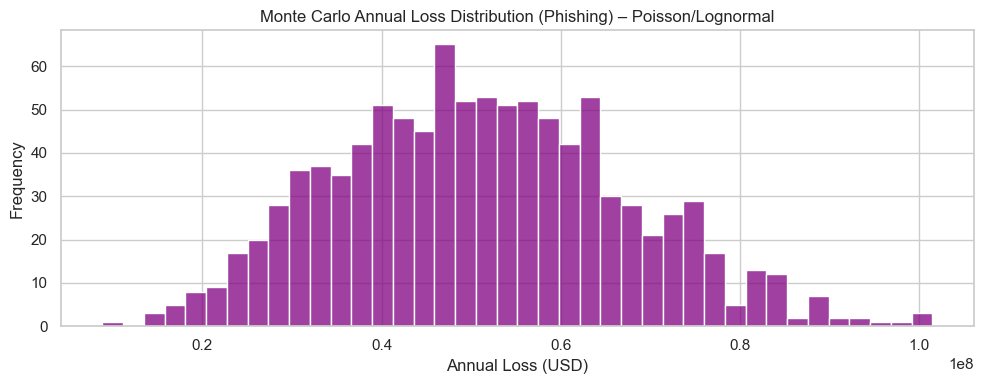

In [396]:
# Frequency: Poisson fit to annual phishing counts
phishing_col = 'action.social.variety.Phishing'
phish_mask = pd.to_numeric(healthcare_df[phishing_col], errors='coerce').fillna(0) == 1
phish_years = pd.to_numeric(healthcare_df.loc[phish_mask, 'timeline.incident.year'], errors='coerce').dropna()
year_counts = phish_years.value_counts()
lam = year_counts.mean()

# Severity: lognormal fit to phishing loss amounts
phish_losses = pd.to_numeric(healthcare_df.loc[phish_mask, 'impact.loss.amount'], errors='coerce').dropna()
shape, loc, scale = lognorm.fit(phish_losses, floc=0)

# Monte Carlo simulation (frequency–severity)
trials = 1000
annual_losses = []
for _ in range(trials):
  incidents = poisson(mu=lam).rvs()
  if incidents == 0:
      annual_losses.append(0)
      continue
  severity_samples = lognorm(s=shape, scale=scale).rvs(size=incidents)
  annual_losses.append(severity_samples.sum())

annual_losses = np.array(annual_losses)
summary = pd.Series(annual_losses).describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
display(summary.rename('Annual Loss'))

# Plot simulated annual loss distribution
plt.figure(figsize=(10, 4))
sns.histplot(annual_losses, bins=40, color='purple')
plt.title('Monte Carlo Annual Loss Distribution (Phishing) – Poisson/Lognormal')
plt.xlabel('Annual Loss (USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

,action,vector,likelihood,median_impact,p90_impact,incident_count
0,error,Carelessness,0.254027,4513405.5,6073646.3,552
1,error,Inadequate processes,0.017027,4243812.0,5676089.8,37
2,error,Other,0.006903,4303615.0,5853647.4,15
3,error,Random error,0.005062,4942462.0,6401218.0,11


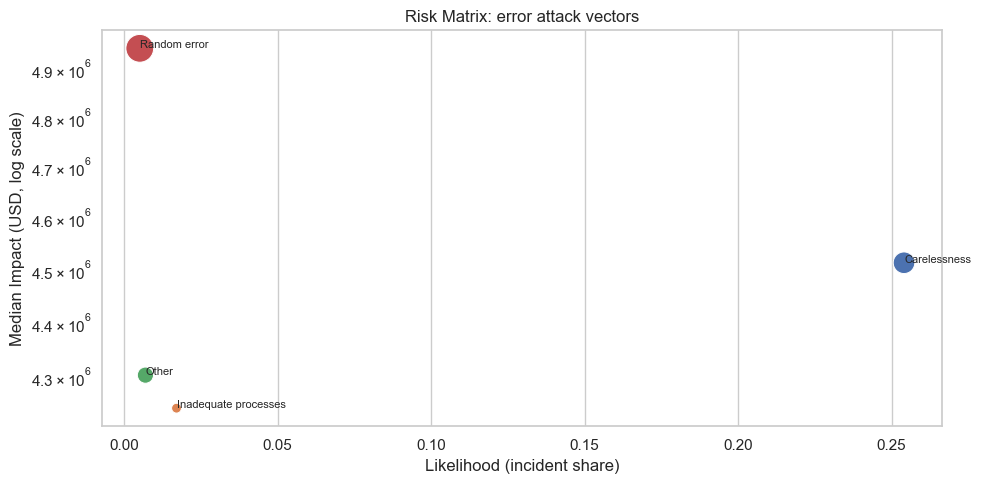

,action,vector,likelihood,median_impact,p90_impact,incident_count
11,hacking,Web application,0.072711,4673930.5,6146782.5,158
7,hacking,Other,0.010124,5234278.5,6013463.8,22
4,hacking,Backdoor or C2,0.005983,5166288.0,6234349.8,13
8,hacking,Partner,0.003682,3972334.5,6151969.2,8
9,hacking,Physical access,0.003221,4614231.0,5484833.0,7
6,hacking,Desktop sharing software,0.002301,6072157.0,6257445.6,5
5,hacking,Desktop sharing,0.001381,3395270.0,5536779.6,3
10,hacking,VPN,0.000920,4546940.5,5721724.9,2


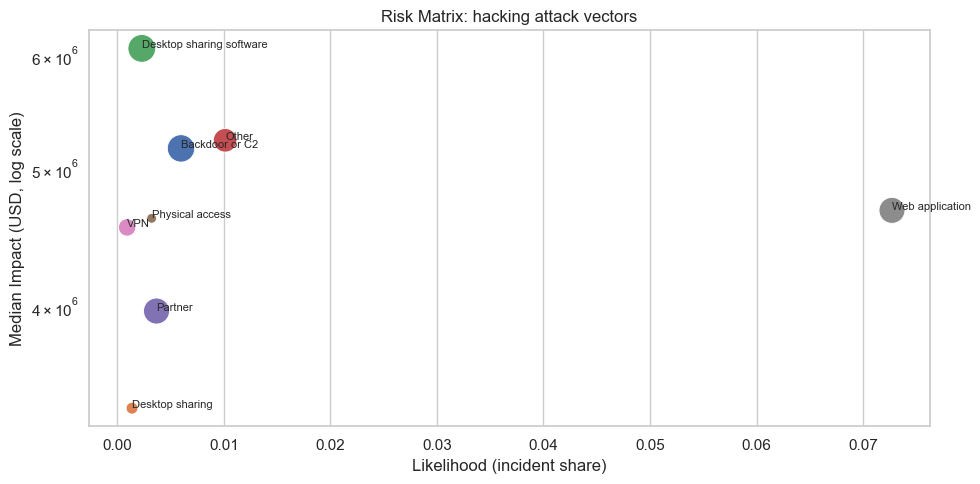

,action,vector,likelihood,median_impact,p90_impact,incident_count
14,malware,Email attachment,0.017948,4330648.0,5945004.0,39
15,malware,Email link,0.011505,4767763.0,6219097.0,25
12,malware,Direct install,0.009664,4363405.0,5807099.0,21
16,malware,Network propagation,0.004602,5961746.0,6474757.0,10
18,malware,Software update,0.002761,4685633.5,6434996.0,6
20,malware,Web drive-by,0.002761,4454205.5,6166834.0,6
13,malware,Download by malware,0.000920,5631703.0,6119525.4,2
17,malware,Remote injection,0.000920,3497757.5,4110667.5,2
19,malware,Web download,0.000920,4807619.0,5094554.2,2


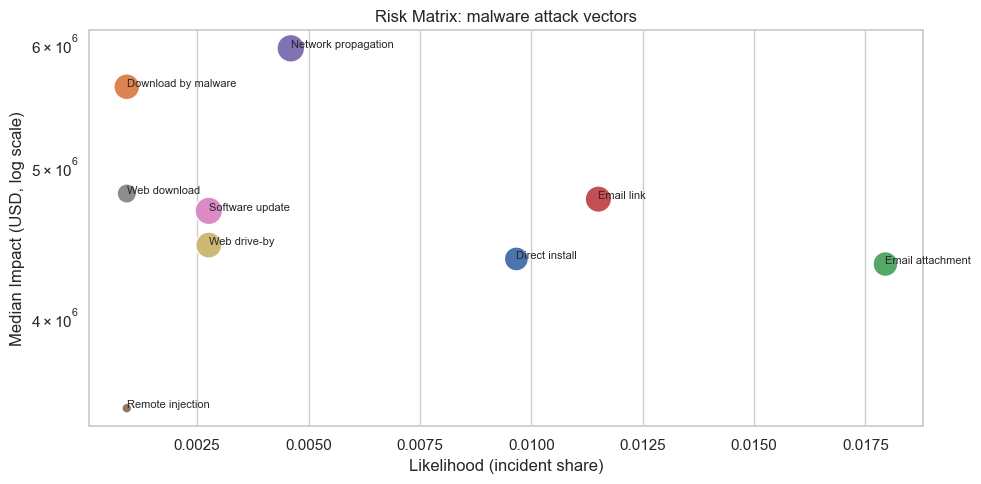

,action,vector,likelihood,median_impact,p90_impact,incident_count
21,misuse,LAN access,0.195582,4652684.0,6221868.2,425
24,misuse,Physical access,0.069489,4670103.0,6096228.0,151
22,misuse,Non-corporate,0.006903,4390176.0,6058722.8,15
25,misuse,Remote access,0.004602,4802841.5,5874001.9,10
23,misuse,Other,0.001841,3766699.0,4104385.5,4


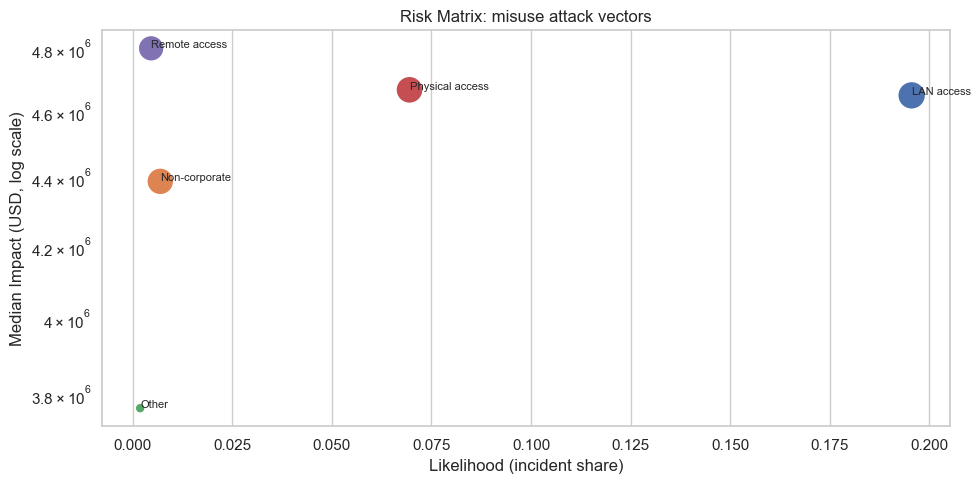

,action,vector,likelihood,median_impact,p90_impact,incident_count
38,physical,Victim work area,0.146341,4741944.5,6185204.5,318
30,physical,Personal vehicle,0.069029,4467829.0,6067594.9,150
29,physical,Personal residence,0.023010,4694497.0,6350228.9,50
27,physical,Partner facility,0.020249,5467607.0,6330871.9,44
37,physical,Victim secure area,0.019788,4601018.0,6137706.4,43
35,physical,Victim grounds,0.006903,4627159.0,6332314.6,15
28,physical,Partner vehicle,0.005983,5541412.0,5965580.4,13
32,physical,Public facility,0.004602,4382208.0,5141559.4,10
31,physical,Privileged access,0.003682,4202306.5,5373257.1,8
26,physical,Other,0.003221,4941620.0,6054047.4,7


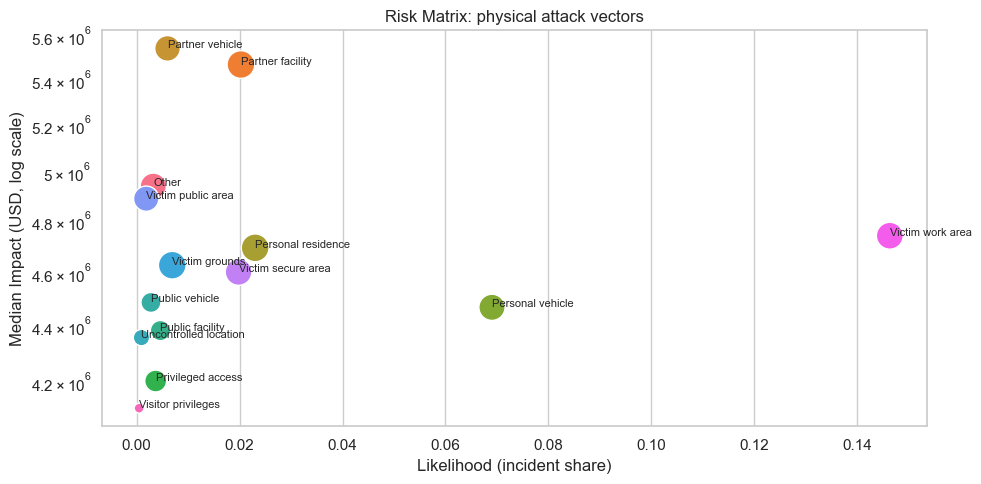

,action,vector,likelihood,median_impact,p90_impact,incident_count
41,social,Email,0.034514,4954409.0,6182462.8,75
42,social,In-person,0.007363,4713860.5,5595500.5,16
40,social,Documents,0.002761,5616519.0,6187751.5,6
44,social,Phone,0.001381,5388174.0,5714554.0,3
47,social,Website,0.000920,4988294.0,5583093.2,2
43,social,Other,0.000460,5944243.0,5944243.0,1
45,social,Social media,0.000460,5796149.0,5796149.0,1
46,social,Software,0.000460,4135786.0,4135786.0,1


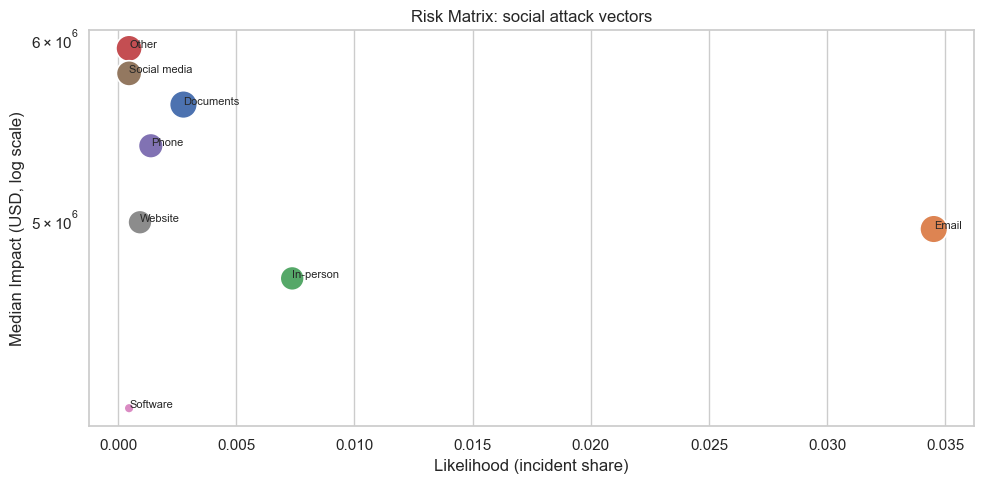

In [394]:
loss_col = 'impact.loss.amount'
loss_values = pd.to_numeric(healthcare_df[loss_col], errors='coerce').fillna(0)
vector_cols = [c for c in healthcare_df.columns if '.vector.' in c]
total_incidents = len(healthcare_df)

records = []
for vector_col in vector_cols:
  parts = vector_col.split('.')
  if len(parts) < 4:
      continue
  action_name = parts[1]  # e.g., 'Malware', 'Social'
  vector_name = vector_col.split('.vector.', 1)[1]
  flags = pd.to_numeric(healthcare_df[vector_col], errors='coerce').fillna(0)
  count = (flags == 1).sum()
  if count == 0:
      continue

  impacts = loss_values[flags == 1]
  records.append({
      'action': action_name,
      'vector': vector_name,
      'likelihood': count / total_incidents,
      'median_impact': impacts.median(),
      'p90_impact': impacts.quantile(0.9),
      'incident_count': count,
  })

vector_risk_df = pd.DataFrame(records)

# Display breakdown per action
for action, group in vector_risk_df.groupby('action'):
  if group.empty:
      continue
  display(group.sort_values('likelihood', ascending=False))

  plt.figure(figsize=(10, 5))
  sns.scatterplot(
      data=group,
      x='likelihood',
      y='median_impact',
      size='p90_impact',
      sizes=(50, 400),
      hue='vector',
      legend=False
  )
  plt.yscale('log')
  plt.title(f'Risk Matrix: {action} attack vectors')
  plt.xlabel('Likelihood (incident share)')
  plt.ylabel('Median Impact (USD, log scale)')

  # add labels to each point
  for _, row in group.iterrows():
      plt.text(row['likelihood'], row['median_impact'], row['vector'], fontsize=8)

  plt.tight_layout()
  plt.show()


In [397]:
loss_col = 'impact.loss.amount'
loss_values = pd.to_numeric(healthcare_df[loss_col], errors='coerce').fillna(0)
vector_cols = [c for c in healthcare_df.columns if '.vector.' in c]

years = pd.to_numeric(healthcare_df['timeline.incident.year'], errors='coerce').dropna().astype(int)
observed_years = years.nunique() or 1  # avoid division by zero

sle_records = []
for vector_col in vector_cols:
  vector_name = vector_col.split('.vector.', 1)[1]
  flags = pd.to_numeric(healthcare_df[vector_col], errors='coerce').fillna(0)
  incident_count = (flags == 1).sum()
  if incident_count == 0:
      continue

  sle = loss_values[flags == 1].mean()                            # Single Loss Exposure
  aro = incident_count / observed_years                            # Annual Rate of Occurrence
  projected_cost = sle * aro                                       # ALE-style projection

  sle_records.append({
      'vector': vector_name,
      'incidents_observed': incident_count,
      'SLE_mean_loss': sle,
      'ARO_per_year': aro,
      'projected_cost': projected_cost,
  })

vector_sle_df = pd.DataFrame(sle_records).sort_values('projected_cost', ascending=False)
display(vector_sle_df.head(15))


,vector,incidents_observed,SLE_mean_loss,ARO_per_year,projected_cost
0,Carelessness,552,4.562434e+06,29.052632,1.325507e+08
21,LAN access,425,4.646689e+06,22.368421,1.039391e+08
38,Victim work area,318,4.655726e+06,16.736842,7.792216e+07
11,Web application,158,4.640812e+06,8.315789,3.859201e+07
24,Physical access,151,4.586239e+06,7.947368,3.644853e+07
30,Personal vehicle,150,4.601501e+06,7.894737,3.632764e+07
41,Email,75,4.840436e+06,3.947368,1.910698e+07
29,Personal residence,50,4.635749e+06,2.631579,1.219934e+07
27,Partner facility,44,5.014120e+06,2.315789,1.161165e+07
37,Victim secure area,43,4.676942e+06,2.263158,1.058466e+07
